In [1]:
import os
import torch
from copy import deepcopy
import numpy as np
import xarray as xr
import pandas as pd
import torch.nn as nn
import random
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.models as models
from sklearn import preprocessing
import zipfile
import shutil
from sklearn.preprocessing import StandardScaler
device = 'cuda' if torch.cuda.is_available() else 'cpu'   
device

'cuda'

In [2]:
def set_seed(seed = 427):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)

In [3]:
class EarthDataSet(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data['sst'])

    def __getitem__(self, idx):   
        return (self.data['sst'][idx], self.data['t300'][idx], self.data['ua'][idx], self.data['va'][idx]), self.data['label'][idx]

In [4]:
def fit_data(data_list, fit=True):
    a,b,c,d = data_list[0].shape
    all_data = []
    for data in data_list:
        new_data = data.reshape(-1)
        all_data.append(new_data)
    all_data = np.stack(all_data,1)
    print(all_data.shape)
    if fit:
        standardScaler.fit(all_data)
        print("fit train data")
    all_data = standardScaler.transform(all_data)
    res_data = []
    for i in range(all_data.shape[1]):
        data = all_data[:,i].reshape(a,b,c,d)
        res_data.append(data)
    return res_data

In [5]:
def load_data():
    # CMIP data    
    train = xr.open_dataset('tcdata/enso_round1_train_20210201/CMIP_train.nc')
    label = xr.open_dataset('tcdata/enso_round1_train_20210201/CMIP_label.nc')    
   
    train_sst = train['sst'][:, :12].values.astype('float64')  # (4645, 12, 24, 72)
    train_t300 = train['t300'][:, :12].values.astype('float64')
    train_ua = train['ua'][:, :12].values.astype('float64')
    train_va = train['va'][:, :12].values.astype('float64')
    train_label = label['nino'][:, 12:36].values.astype('float64')

    train_ua = np.nan_to_num(train_ua) # trans nan to 0
    train_va = np.nan_to_num(train_va)
    train_t300 = np.nan_to_num(train_t300)
    train_sst = np.nan_to_num(train_sst)
    
#     data_list = [train_sst,train_t300,train_ua,train_va]
#     train_sst,train_t300,train_ua,train_va = fit_data(data_list, fit=True)

    # SODA data    
    train2 = xr.open_dataset('tcdata/enso_round1_train_20210201/SODA_train.nc')
    label2 = xr.open_dataset('tcdata/enso_round1_train_20210201/SODA_label.nc')
    
    train_sst2 = train2['sst'][:, :12].values.astype('float64')  # (100, 12, 24, 72)
    train_t3002 = train2['t300'][:, :12].values.astype('float64')
    train_ua2 = train2['ua'][:, :12].values.astype('float64')
    train_va2 = train2['va'][:, :12].values.astype('float64')
    train_label2 = label2['nino'][:, 12:36].values.astype('float64')
    
    train_sst2 = np.nan_to_num(train_sst2) # trans nan to 0
    train_t3002 = np.nan_to_num(train_t3002)
    train_ua2 = np.nan_to_num(train_ua2)
    train_va2 = np.nan_to_num(train_va2)
    
#     data_list = [train_sst2,train_t3002,train_ua2,train_va2]
#     train_sst2,train_t3002,train_ua2,train_va2 = fit_data(data_list, fit=False)

    dict_cmip = {
        'sst':train_sst,
        't300':train_t300,
        'ua':train_ua,
        'va': train_va,
        'label': train_label}
    dict_soda = {
        'sst':train_sst2,
        't300':train_t3002,
        'ua':train_ua2,
        'va': train_va2,
        'label': train_label2}
    
    cmip_dataset = EarthDataSet(dict_cmip)
    soda_dataset = EarthDataSet(dict_soda)
    
    train_1, valid_1 = random_split(cmip_dataset, [4545, 100])
    train_2, valid_2 = random_split(soda_dataset, [90, 10])
    
    train_dataset = train_1 + train_2 + train_2 + train_2 + train_2 + train_2 
    valid_dataset = valid_2 + valid_1 + valid_2 + valid_2 + valid_2 + valid_2
    
    return train_dataset, valid_dataset

In [6]:
set_seed()
standardScaler = StandardScaler()
train_dataset, valid_dataset = load_data()      
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

In [7]:
def coreff(x, y):
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    c1 = sum((x - x_mean) * (y - y_mean))
    c2 = sum((x - x_mean)**2) * sum((y - y_mean)**2)
    return c1/np.sqrt(c2)

def rmse(preds, y):
    r = np.sqrt(sum((preds - y)**2) / preds.shape[0])
    return r

def eval_score(preds, label):
    acskill_socre = 0
    rmse_score = 0
    a = [1.5]*4 + [2]*7 + [3]*7 + [4]*6
    for i in range(24):
        r = rmse(preds[:, i], label[:, i], ) # T时刻 (100,)
        cor = coreff(preds[:, i], label[:, i], )
    
        rmse_score += r
        acskill_socre += a[i] * np.log(i+1) * cor
    print("acskill_socre:{}, rmse_score:{}".format(2/3*acskill_socre, rmse_score))
    return 2/3 * acskill_socre - rmse_score

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
def train(num_epochs):
    best_score = -99
    loss_epoch = []
    score_epoch = []
    epoch = -1
    model.eval()
    y_true, y_pred = [], []
    for step, ((sst, t300, ua, va), label) in enumerate(valid_loader):
        sst = sst.to(device).float()
        t300 = t300.to(device).float()
        ua = ua.to(device).float()
        va = va.to(device).float()
        label = label.to(device).float()
        preds = model(sst, t300, ua, va)

        y_pred.append(preds)
        y_true.append(label)

    y_true = torch.cat(y_true, axis=0).cpu().detach().numpy()
    y_pred = torch.cat(y_pred, axis=0).cpu().detach().numpy()
    x_month = np.arange(24)
    score = eval_score(y_true, y_pred)
    print('Epoch: {}, Valid Score: {}\n'.format(epoch+1,score))    
        
    for epoch in range(num_epochs):
        model.train()
        all_loss = []
        for step, ((sst, t300, ua, va), label) in enumerate(train_loader):                
            sst = sst.to(device).float()
            t300 = t300.to(device).float()
            ua = ua.to(device).float()
            va = va.to(device).float()
            optimizer.zero_grad()
            label = label.to(device).float()
            preds = model(sst, t300, ua, va)
            loss = loss_fn(preds, label)
            loss.backward()
            optimizer.step()
            all_loss.append(loss.item())
            if step%20 == 0:
                print('Step: {}, Train Loss: {}'.format(step, loss))
        print('Epoch: {}, Train loss: {}'.format(epoch+1, np.mean(all_loss)))
        loss_epoch.append(np.mean(all_loss))

        model.eval()
        y_true, y_pred = [], []
        for step, ((sst, t300, ua, va), label) in enumerate(valid_loader):
            sst = sst.to(device).float()
            t300 = t300.to(device).float()
            ua = ua.to(device).float()
            va = va.to(device).float()
            label = label.to(device).float()
            preds = model(sst, t300, ua, va)

            y_pred.append(preds)
            y_true.append(label)

        y_true = torch.cat(y_true, axis=0).cpu().detach().numpy()
        y_pred = torch.cat(y_pred, axis=0).cpu().detach().numpy()
        x_month = np.arange(24)
        score = eval_score(y_true, y_pred)
        score_epoch.append(score)
        print('Epoch: {}, Valid Score: {}'.format(epoch+1,score))
        
        torch.save(model.state_dict(), './models/basemodel_epoch_{}.pt'.format(epoch+1))
        if score > best_score:
            torch.save(model.state_dict(), './models/basemodel_best.pt')
            print('Model saved successfully')
            best_score = score
            
        # figure
        plt.figure(figsize = (10,5))
        for i in range(23):
            plt.subplot(5,5,i+1)
            plt.plot(x_month, y_true[i],color='red')
            plt.plot(x_month, y_pred[i],color='blue')
        plt.subplot(5,5,24)
        plt.plot(np.arange(len(loss_epoch))[:20],loss_epoch[-20:])
        plt.subplot(5,5,25)
        plt.plot(np.arange(len(score_epoch)),score_epoch)
        plt.tight_layout()
        plt.show()
        

In [10]:
class CNN_Model(nn.Module):
    def __init__(self):
        super(CNN_Model, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(4,8))) 
        self.conv2 = nn.Sequential(nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(4,8))) 
        self.conv3 = nn.Sequential(nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(4,8))) 
        self.conv4 = nn.Sequential(nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(4,8))) 
        
        self.batch_norm = nn.BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True)
#         self.lstm = nn.LSTM(input_size = 1540 * 4, hidden_size = 256, num_layers=2, batch_first=True, bidirectional=False)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 128))
        self.linear = nn.Linear(128, 24)

    def forward(self, sst, t300, ua, va):
        sst = self.conv1(sst)  # batch * 12 * (24 - 2) * (72 -2)
        t300 = self.conv2(t300)
        ua = self.conv3(ua)
        va = self.conv4(va)

        sst = torch.flatten(sst, start_dim=2)  # batch * 12 * 1540
        t300 = torch.flatten(t300, start_dim=2)
        ua = torch.flatten(ua, start_dim=2)
        va = torch.flatten(va, start_dim=2)  
        
        x = torch.cat([sst, t300, ua, va], dim=-1) # batch * 12 * (1540 * 4)
        x = self.batch_norm(x)
#         x, (h_n, c_n) = self.lstm(x)
#         x = x[:,-1]
        x = self.avgpool(x).squeeze(dim=-2)
        x = self.linear(x)
        return x

In [11]:
model = CNN_Model()
device = 'cuda' if torch.cuda.is_available() else 'cpu'   
optimizer = torch.optim.Adam(model.parameters(), lr=8e-5)
loss_fn = nn.MSELoss()

model = model.to(device)
loss_fn = loss_fn.to(device)

In [12]:
print('{} : all params: {:4f}M'.format(model._get_name(), sum(p.numel() for p in model.parameters()) / 1000 / 1000))

CNN_Model : all params: 0.021600M


In [13]:
model

CNN_Model(
  (conv1): Sequential(
    (0): Conv2d(12, 12, kernel_size=(4, 8), stride=(1, 1))
  )
  (conv2): Sequential(
    (0): Conv2d(12, 12, kernel_size=(4, 8), stride=(1, 1))
  )
  (conv3): Sequential(
    (0): Conv2d(12, 12, kernel_size=(4, 8), stride=(1, 1))
  )
  (conv4): Sequential(
    (0): Conv2d(12, 12, kernel_size=(4, 8), stride=(1, 1))
  )
  (batch_norm): BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (avgpool): AdaptiveAvgPool2d(output_size=(1, 128))
  (linear): Linear(in_features=128, out_features=24, bias=True)
)

acskill_socre:-0.9360363727874987, rmse_score:19.476722450248946
Epoch: 0, Valid Score: -20.412758823036445

Step: 0, Train Loss: 0.8683733940124512
Step: 20, Train Loss: 0.9598302841186523
Step: 40, Train Loss: 0.6269816160202026
Step: 60, Train Loss: 0.5979685187339783
Step: 80, Train Loss: 0.6918174028396606
Step: 100, Train Loss: 0.6004935503005981
Step: 120, Train Loss: 0.6461473107337952
Step: 140, Train Loss: 0.6192883253097534
Epoch: 1, Train loss: 0.6885429791584137
acskill_socre:29.806874035498808, rmse_score:18.412952690597642
Epoch: 1, Valid Score: 11.393921344901166
Model saved successfully


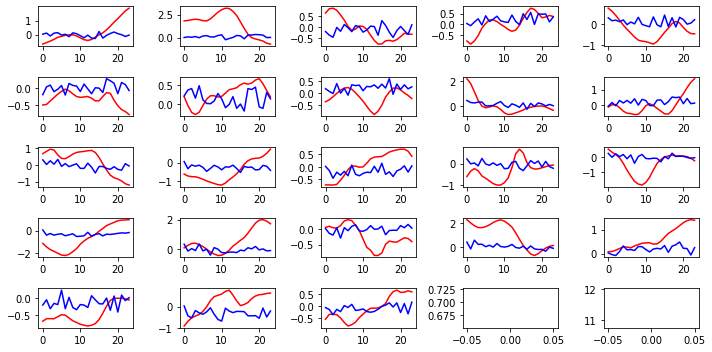

Step: 0, Train Loss: 0.5590702891349792
Step: 20, Train Loss: 0.4238165318965912
Step: 40, Train Loss: 0.5044411420822144
Step: 60, Train Loss: 0.504792332649231
Step: 80, Train Loss: 0.4893946647644043
Step: 100, Train Loss: 0.5580767393112183
Step: 120, Train Loss: 0.47219687700271606
Step: 140, Train Loss: 0.6410366296768188
Epoch: 2, Train loss: 0.6132269638359167
acskill_socre:33.47292899296974, rmse_score:18.063934373015226
Epoch: 2, Valid Score: 15.408994619954516
Model saved successfully


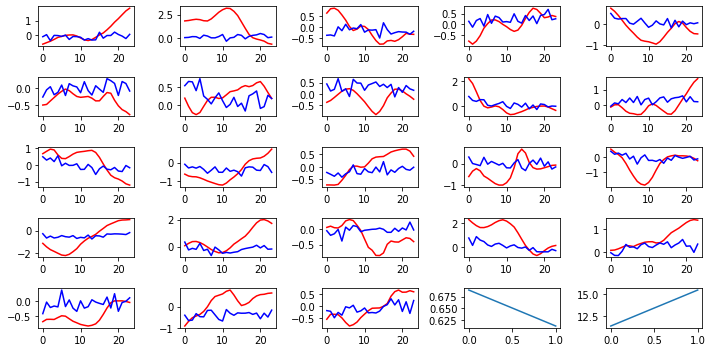

Step: 0, Train Loss: 0.4977477490901947
Step: 20, Train Loss: 0.5497804284095764
Step: 40, Train Loss: 0.5890598297119141
Step: 60, Train Loss: 0.4416104257106781
Step: 80, Train Loss: 0.6974035501480103
Step: 100, Train Loss: 0.620155930519104
Step: 120, Train Loss: 0.551594614982605
Step: 140, Train Loss: 0.7181903719902039
Epoch: 3, Train loss: 0.5735177965300857
acskill_socre:36.22276091953266, rmse_score:17.858399081841124
Epoch: 3, Valid Score: 18.364361837691536
Model saved successfully


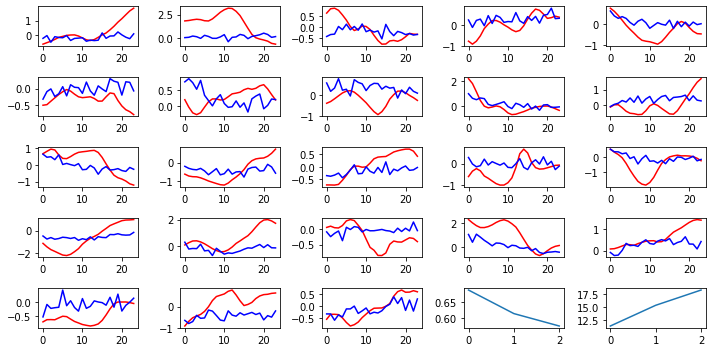

Step: 0, Train Loss: 0.7481621503829956
Step: 20, Train Loss: 0.7353121638298035
Step: 40, Train Loss: 0.4373854994773865
Step: 60, Train Loss: 0.5285899043083191
Step: 80, Train Loss: 0.44005128741264343
Step: 100, Train Loss: 0.4994889199733734
Step: 120, Train Loss: 0.3870082497596741
Step: 140, Train Loss: 0.5447617173194885
Epoch: 4, Train loss: 0.547503147155616
acskill_socre:38.12896978087827, rmse_score:17.68385093770199
Epoch: 4, Valid Score: 20.44511884317628
Model saved successfully


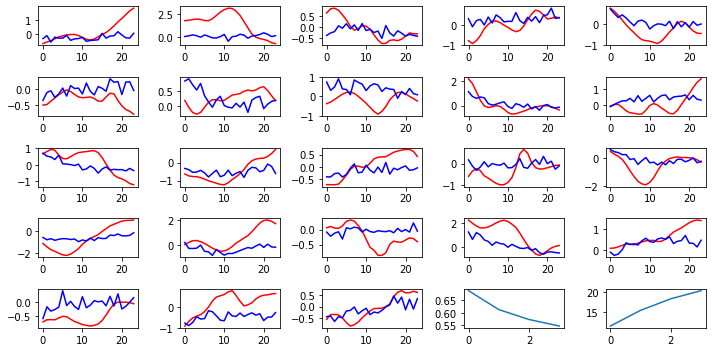

Step: 0, Train Loss: 0.6615324020385742
Step: 20, Train Loss: 0.542023777961731
Step: 40, Train Loss: 0.49091774225234985
Step: 60, Train Loss: 0.42896854877471924
Step: 80, Train Loss: 0.5171951055526733
Step: 100, Train Loss: 0.6561317443847656
Step: 120, Train Loss: 0.3934744596481323
Step: 140, Train Loss: 0.5738393068313599
Epoch: 5, Train loss: 0.5341999029657644
acskill_socre:39.8425885283443, rmse_score:17.530033916604342
Epoch: 5, Valid Score: 22.31255461173996
Model saved successfully


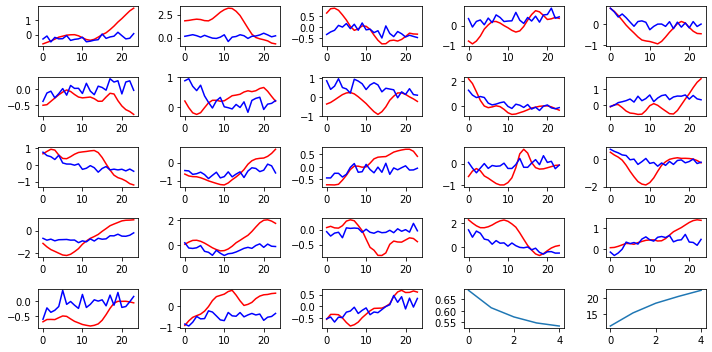

Step: 0, Train Loss: 0.4476783871650696
Step: 20, Train Loss: 0.31976938247680664
Step: 40, Train Loss: 0.419120192527771
Step: 60, Train Loss: 0.37394365668296814
Step: 80, Train Loss: 0.34043776988983154
Step: 100, Train Loss: 0.5432385206222534
Step: 120, Train Loss: 0.6291264295578003
Step: 140, Train Loss: 0.5058100819587708
Epoch: 6, Train loss: 0.5207634639398308
acskill_socre:40.261236199683594, rmse_score:17.450692651006644
Epoch: 6, Valid Score: 22.81054354867695
Model saved successfully


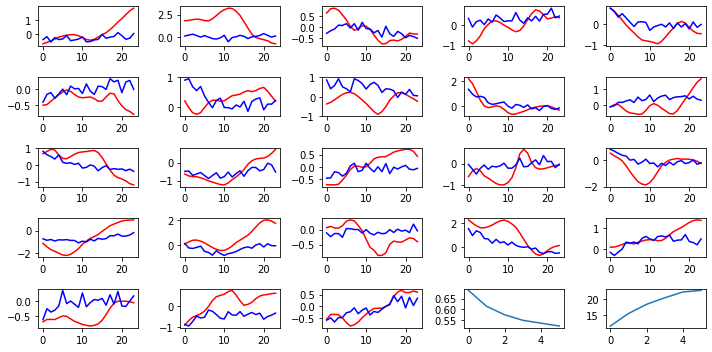

Step: 0, Train Loss: 0.5020934343338013
Step: 20, Train Loss: 0.5261138081550598
Step: 40, Train Loss: 0.49185341596603394
Step: 60, Train Loss: 0.4602082669734955
Step: 80, Train Loss: 0.5142179727554321
Step: 100, Train Loss: 0.5868458151817322
Step: 120, Train Loss: 0.6096634864807129
Step: 140, Train Loss: 0.5490420460700989
Epoch: 7, Train loss: 0.5136909560792765
acskill_socre:41.86120075967221, rmse_score:17.288401065603413
Epoch: 7, Valid Score: 24.572799694068795
Model saved successfully


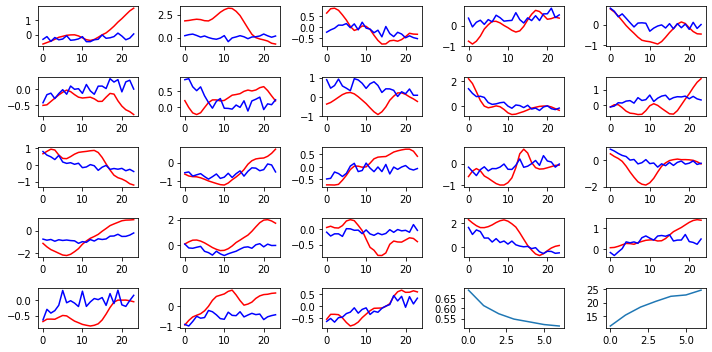

Step: 0, Train Loss: 0.3563469648361206
Step: 20, Train Loss: 0.4249662756919861
Step: 40, Train Loss: 0.3412942886352539
Step: 60, Train Loss: 0.4735713601112366
Step: 80, Train Loss: 0.4323280453681946
Step: 100, Train Loss: 0.5027241110801697
Step: 120, Train Loss: 0.5625696182250977
Step: 140, Train Loss: 0.6152574419975281
Epoch: 8, Train loss: 0.5061337947845459
acskill_socre:42.61743189940161, rmse_score:17.19143837882462
Epoch: 8, Valid Score: 25.425993520576988
Model saved successfully


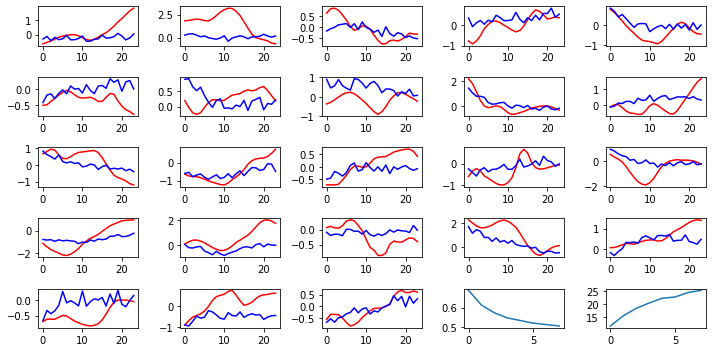

Step: 0, Train Loss: 0.5914726853370667
Step: 20, Train Loss: 0.585038423538208
Step: 40, Train Loss: 0.3826247453689575
Step: 60, Train Loss: 0.37865036725997925
Step: 80, Train Loss: 0.6800505518913269
Step: 100, Train Loss: 0.4042859971523285
Step: 120, Train Loss: 0.4637375473976135
Step: 140, Train Loss: 0.5009010434150696
Epoch: 9, Train loss: 0.5002148963843182
acskill_socre:43.3255645712931, rmse_score:17.072877155859484
Epoch: 9, Valid Score: 26.252687415433616
Model saved successfully


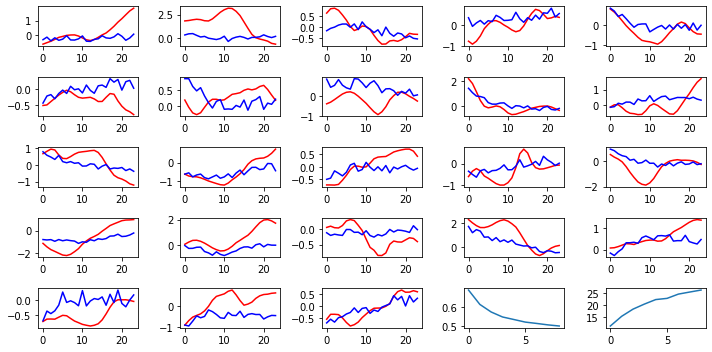

Step: 0, Train Loss: 0.525464653968811
Step: 20, Train Loss: 0.4211411476135254
Step: 40, Train Loss: 0.6653687953948975
Step: 60, Train Loss: 0.49609774351119995
Step: 80, Train Loss: 0.5789400339126587
Step: 100, Train Loss: 0.5323352813720703
Step: 120, Train Loss: 0.3531796336174011
Step: 140, Train Loss: 0.606623113155365
Epoch: 10, Train loss: 0.4982642835112894
acskill_socre:43.73729691838941, rmse_score:17.037015579851417
Epoch: 10, Valid Score: 26.700281338537994
Model saved successfully


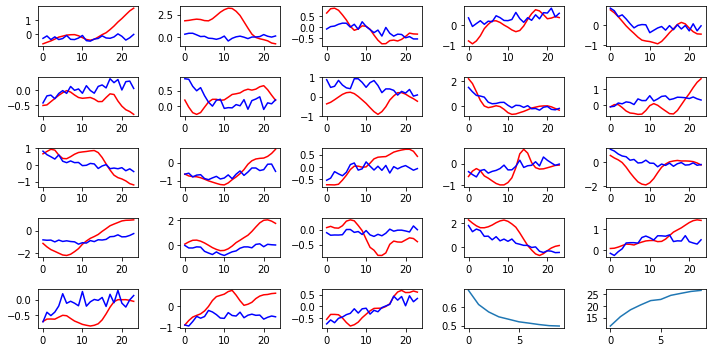

Step: 0, Train Loss: 0.308702677488327
Step: 20, Train Loss: 0.4766228199005127
Step: 40, Train Loss: 0.4704165458679199
Step: 60, Train Loss: 0.5334036350250244
Step: 80, Train Loss: 0.5298796892166138
Step: 100, Train Loss: 0.6436011791229248
Step: 120, Train Loss: 0.6243601441383362
Step: 140, Train Loss: 0.6456878185272217
Epoch: 11, Train loss: 0.4909862524764553
acskill_socre:44.07047110218614, rmse_score:16.9364454926913
Epoch: 11, Valid Score: 27.13402560949484
Model saved successfully


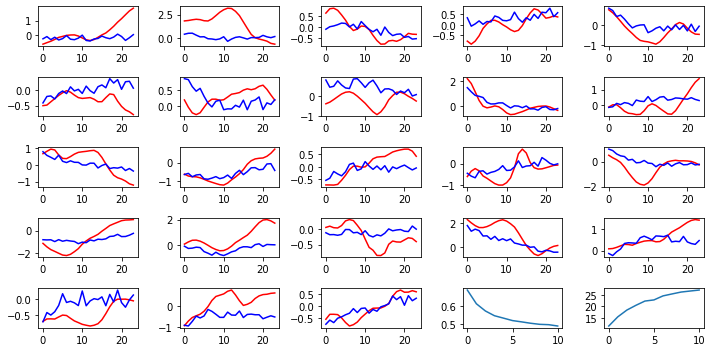

Step: 0, Train Loss: 0.3895931839942932
Step: 20, Train Loss: 0.4415028691291809
Step: 40, Train Loss: 0.5022290945053101
Step: 60, Train Loss: 0.4612113833427429
Step: 80, Train Loss: 0.6785120964050293
Step: 100, Train Loss: 0.6198577880859375
Step: 120, Train Loss: 0.4503105878829956
Step: 140, Train Loss: 0.506472110748291
Epoch: 12, Train loss: 0.48716822551314237
acskill_socre:44.877067196011126, rmse_score:16.817910891046253
Epoch: 12, Valid Score: 28.059156304964873
Model saved successfully


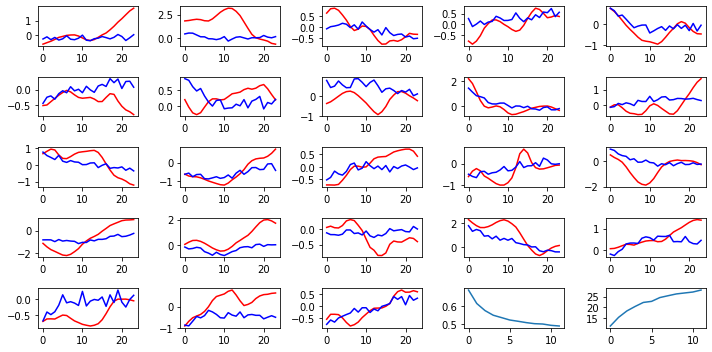

Step: 0, Train Loss: 0.3898835778236389
Step: 20, Train Loss: 0.5221477746963501
Step: 40, Train Loss: 0.5868955850601196
Step: 60, Train Loss: 0.7981988787651062
Step: 80, Train Loss: 0.38597989082336426
Step: 100, Train Loss: 0.46613121032714844
Step: 120, Train Loss: 0.4932689666748047
Step: 140, Train Loss: 0.5811538696289062
Epoch: 13, Train loss: 0.48672443723223013
acskill_socre:45.435829997970714, rmse_score:16.755376617123954
Epoch: 13, Valid Score: 28.68045338084676
Model saved successfully


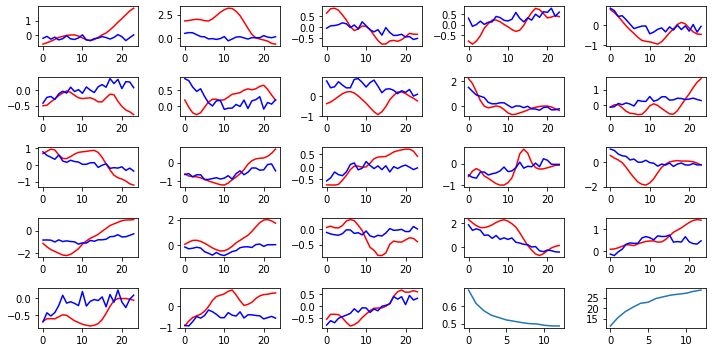

Step: 0, Train Loss: 0.4177279472351074
Step: 20, Train Loss: 0.5021678805351257
Step: 40, Train Loss: 0.428078830242157
Step: 60, Train Loss: 0.41274213790893555
Step: 80, Train Loss: 0.4274181127548218
Step: 100, Train Loss: 0.48983749747276306
Step: 120, Train Loss: 0.7035316228866577
Step: 140, Train Loss: 0.5135098695755005
Epoch: 14, Train loss: 0.48452580174443066
acskill_socre:46.01757157064077, rmse_score:16.674012699293584
Epoch: 14, Valid Score: 29.343558871347184
Model saved successfully


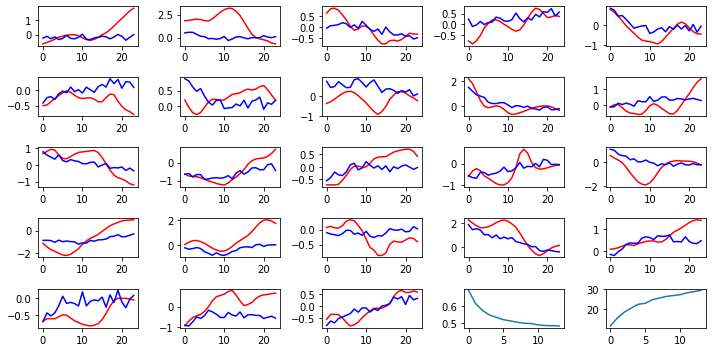

Step: 0, Train Loss: 0.4677930772304535
Step: 20, Train Loss: 0.45091769099235535
Step: 40, Train Loss: 0.4878627061843872
Step: 60, Train Loss: 0.45286136865615845
Step: 80, Train Loss: 0.49954068660736084
Step: 100, Train Loss: 0.5644752383232117
Step: 120, Train Loss: 0.7578854560852051
Step: 140, Train Loss: 0.41056615114212036
Epoch: 15, Train loss: 0.4793297200445916
acskill_socre:45.6929255629487, rmse_score:16.649286859253408
Epoch: 15, Valid Score: 29.043638703695294


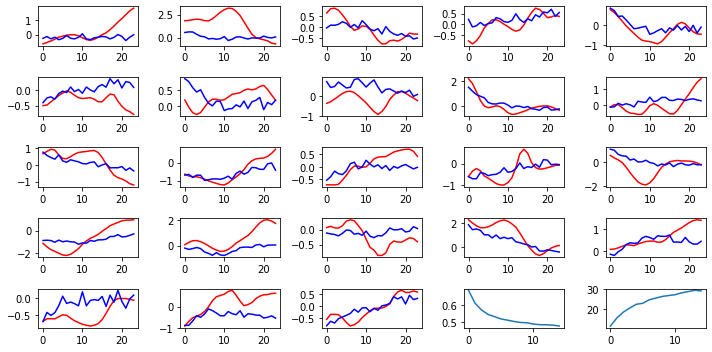

Step: 0, Train Loss: 0.4765133857727051
Step: 20, Train Loss: 0.4086702764034271
Step: 40, Train Loss: 0.5655573606491089
Step: 60, Train Loss: 0.4153522849082947
Step: 80, Train Loss: 0.49927935004234314
Step: 100, Train Loss: 0.6617968082427979
Step: 120, Train Loss: 0.5469138622283936
Step: 140, Train Loss: 0.5283517241477966
Epoch: 16, Train loss: 0.476101530205672
acskill_socre:46.66243435682524, rmse_score:16.549202004138138
Epoch: 16, Valid Score: 30.1132323526871
Model saved successfully


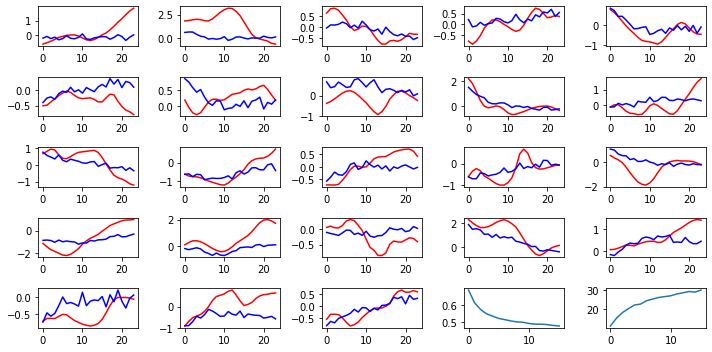

Step: 0, Train Loss: 0.3994635045528412
Step: 20, Train Loss: 0.47724470496177673
Step: 40, Train Loss: 0.3493404984474182
Step: 60, Train Loss: 0.36270421743392944
Step: 80, Train Loss: 0.5424108505249023
Step: 100, Train Loss: 0.575066328048706
Step: 120, Train Loss: 0.5240607261657715
Step: 140, Train Loss: 0.38210636377334595
Epoch: 17, Train loss: 0.4781448360840986
acskill_socre:47.56942876247807, rmse_score:16.441948660620888
Epoch: 17, Valid Score: 31.12748010185718
Model saved successfully


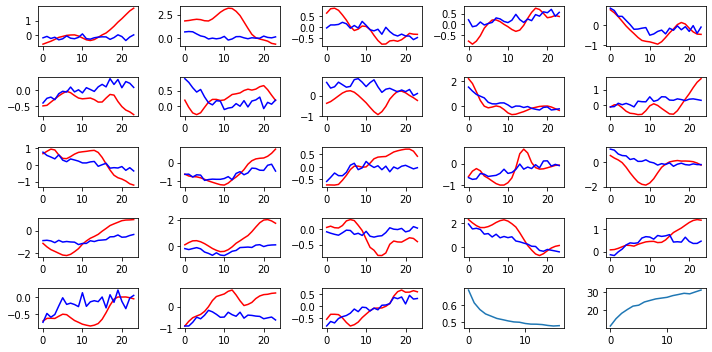

Step: 0, Train Loss: 0.3720371127128601
Step: 20, Train Loss: 0.6840915679931641
Step: 40, Train Loss: 0.4217338562011719
Step: 60, Train Loss: 0.4837753474712372
Step: 80, Train Loss: 0.4237459599971771
Step: 100, Train Loss: 0.6284966468811035
Step: 120, Train Loss: 0.6142123937606812
Step: 140, Train Loss: 0.40122395753860474
Epoch: 18, Train loss: 0.47264370265280364
acskill_socre:47.72283480162162, rmse_score:16.40759384677188
Epoch: 18, Valid Score: 31.31524095484974
Model saved successfully


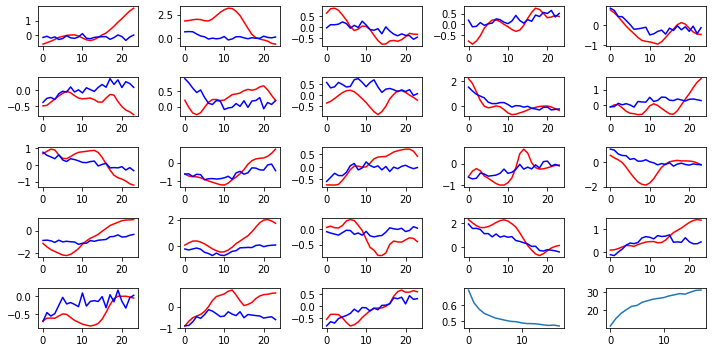

Step: 0, Train Loss: 0.5090649724006653
Step: 20, Train Loss: 0.576313853263855
Step: 40, Train Loss: 0.44622156023979187
Step: 60, Train Loss: 0.4110434949398041
Step: 80, Train Loss: 0.43926191329956055
Step: 100, Train Loss: 0.4211878180503845
Step: 120, Train Loss: 0.3154866695404053
Step: 140, Train Loss: 0.3716828227043152
Epoch: 19, Train loss: 0.46879053201265397
acskill_socre:48.27180964759046, rmse_score:16.333527505175837
Epoch: 19, Valid Score: 31.93828214241462
Model saved successfully


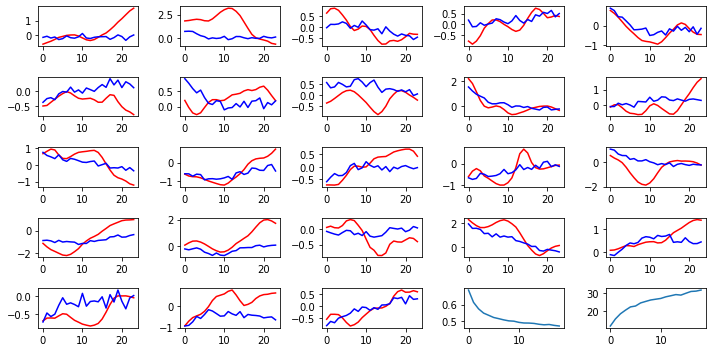

Step: 0, Train Loss: 0.5575252771377563
Step: 20, Train Loss: 0.3170093297958374
Step: 40, Train Loss: 0.3566793203353882
Step: 60, Train Loss: 0.3693722188472748
Step: 80, Train Loss: 0.5779650211334229
Step: 100, Train Loss: 0.43983787298202515
Step: 120, Train Loss: 0.5380963683128357
Step: 140, Train Loss: 0.38264554738998413
Epoch: 20, Train loss: 0.46901096261231
acskill_socre:48.161393532567196, rmse_score:16.34013905296253
Epoch: 20, Valid Score: 31.821254479604665


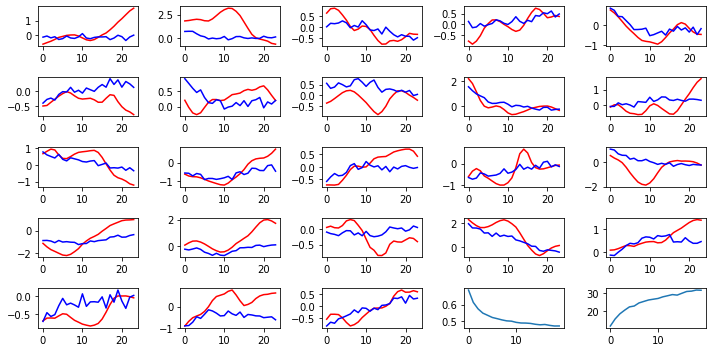

Step: 0, Train Loss: 0.49241942167282104
Step: 20, Train Loss: 0.4790423512458801
Step: 40, Train Loss: 0.4515061378479004
Step: 60, Train Loss: 0.659610390663147
Step: 80, Train Loss: 0.6326651573181152
Step: 100, Train Loss: 0.4869925379753113
Step: 120, Train Loss: 0.3747984766960144
Step: 140, Train Loss: 0.4088619649410248
Epoch: 21, Train loss: 0.4685770149823207
acskill_socre:48.39673892394257, rmse_score:16.251793526538368
Epoch: 21, Valid Score: 32.1449453974042
Model saved successfully


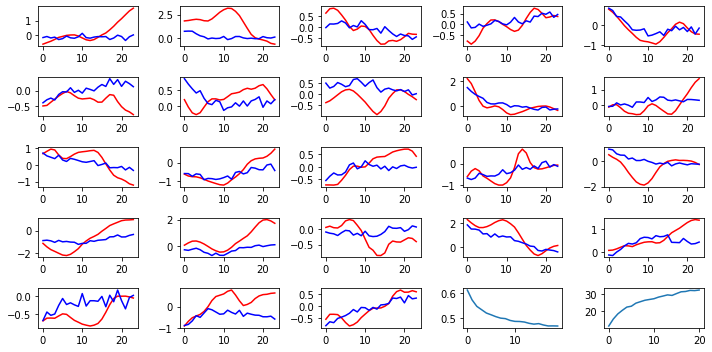

Step: 0, Train Loss: 0.38879936933517456
Step: 20, Train Loss: 0.5194765329360962
Step: 40, Train Loss: 0.38547611236572266
Step: 60, Train Loss: 0.4013370871543884
Step: 80, Train Loss: 0.4862191379070282
Step: 100, Train Loss: 0.4414723813533783
Step: 120, Train Loss: 0.3953225016593933
Step: 140, Train Loss: 0.5308834314346313
Epoch: 22, Train loss: 0.4652599160838279
acskill_socre:49.21786785834939, rmse_score:16.155952110523742
Epoch: 22, Valid Score: 33.06191574782565
Model saved successfully


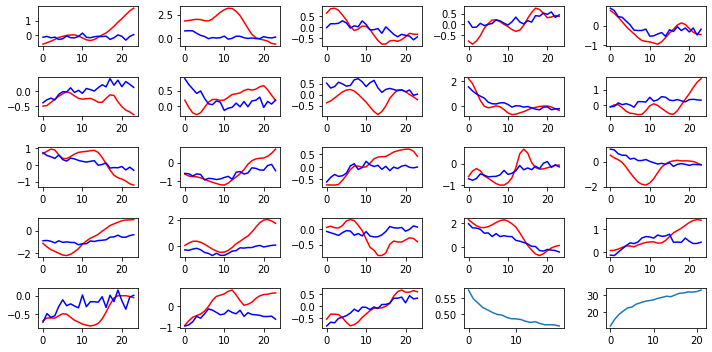

Step: 0, Train Loss: 0.5113551020622253
Step: 20, Train Loss: 0.5468757748603821
Step: 40, Train Loss: 0.36802786588668823
Step: 60, Train Loss: 0.48695942759513855
Step: 80, Train Loss: 0.35230740904808044
Step: 100, Train Loss: 0.3938109874725342
Step: 120, Train Loss: 0.4226207733154297
Step: 140, Train Loss: 0.41015785932540894
Epoch: 23, Train loss: 0.463598018998553
acskill_socre:49.37177590025439, rmse_score:16.116168975605497
Epoch: 23, Valid Score: 33.255606924648895
Model saved successfully


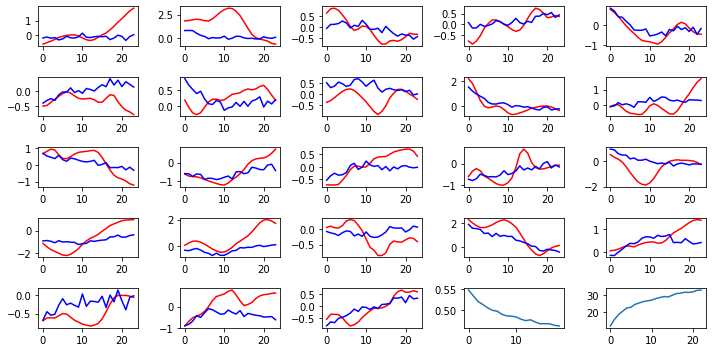

Step: 0, Train Loss: 0.6847958564758301
Step: 20, Train Loss: 0.5009623765945435
Step: 40, Train Loss: 0.43538039922714233
Step: 60, Train Loss: 0.3887964189052582
Step: 80, Train Loss: 0.5011914372444153
Step: 100, Train Loss: 0.6167457103729248
Step: 120, Train Loss: 0.4317794740200043
Step: 140, Train Loss: 0.40356335043907166
Epoch: 24, Train loss: 0.46117790356563154
acskill_socre:49.868356526833296, rmse_score:16.06039716261199
Epoch: 24, Valid Score: 33.807959364221304
Model saved successfully


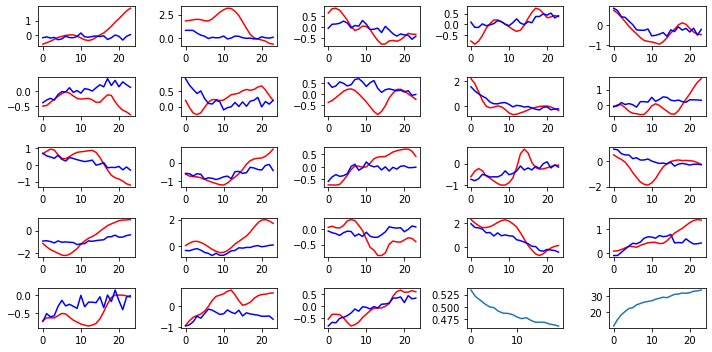

Step: 0, Train Loss: 0.515927791595459
Step: 20, Train Loss: 0.38627514243125916
Step: 40, Train Loss: 0.4217744767665863
Step: 60, Train Loss: 0.34331247210502625
Step: 80, Train Loss: 0.378666490316391
Step: 100, Train Loss: 0.492482990026474
Step: 120, Train Loss: 0.4463171362876892
Step: 140, Train Loss: 0.5547142028808594
Epoch: 25, Train loss: 0.4592953504650456
acskill_socre:49.89597887788871, rmse_score:16.048040658257833
Epoch: 25, Valid Score: 33.847938219630876
Model saved successfully


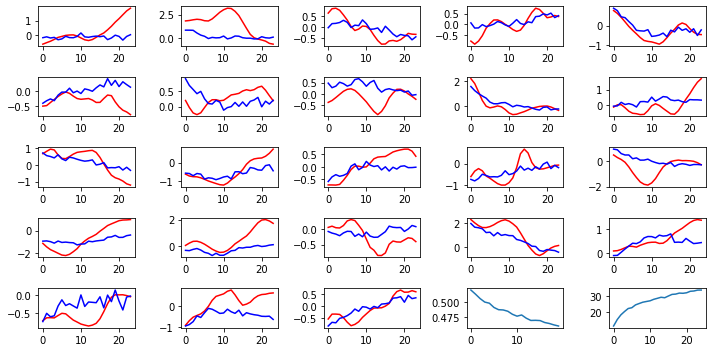

Step: 0, Train Loss: 0.4161289632320404
Step: 20, Train Loss: 0.37504148483276367
Step: 40, Train Loss: 0.5018938779830933
Step: 60, Train Loss: 0.48062023520469666
Step: 80, Train Loss: 0.4749879539012909
Step: 100, Train Loss: 0.4756874442100525
Step: 120, Train Loss: 0.40366697311401367
Step: 140, Train Loss: 0.5202946662902832
Epoch: 26, Train loss: 0.4577313462260422
acskill_socre:50.126240126562195, rmse_score:15.989395652087639
Epoch: 26, Valid Score: 34.13684447447456
Model saved successfully


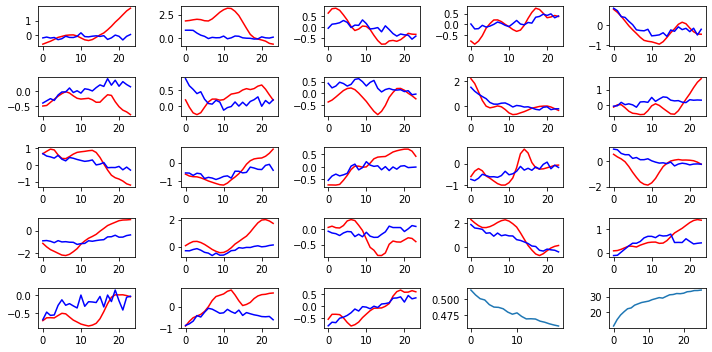

Step: 0, Train Loss: 0.404954731464386
Step: 20, Train Loss: 0.4168968200683594
Step: 40, Train Loss: 0.29110151529312134
Step: 60, Train Loss: 0.527590811252594
Step: 80, Train Loss: 0.42296677827835083
Step: 100, Train Loss: 0.38866108655929565
Step: 120, Train Loss: 0.39388105273246765
Step: 140, Train Loss: 0.3023477792739868
Epoch: 27, Train loss: 0.4584899398551625
acskill_socre:50.87626754368834, rmse_score:15.91838379893279
Epoch: 27, Valid Score: 34.95788374475555
Model saved successfully


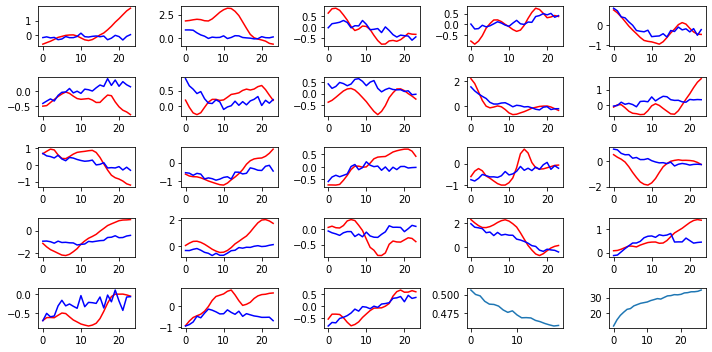

Step: 0, Train Loss: 0.5327576994895935
Step: 20, Train Loss: 0.37422046065330505
Step: 40, Train Loss: 0.5170111060142517
Step: 60, Train Loss: 0.5237674713134766
Step: 80, Train Loss: 0.43432074785232544
Step: 100, Train Loss: 0.35585126280784607
Step: 120, Train Loss: 0.5151759386062622
Step: 140, Train Loss: 0.39681491255760193
Epoch: 28, Train loss: 0.4560681017720775
acskill_socre:50.79967277271527, rmse_score:15.906316615507613
Epoch: 28, Valid Score: 34.893356157207656


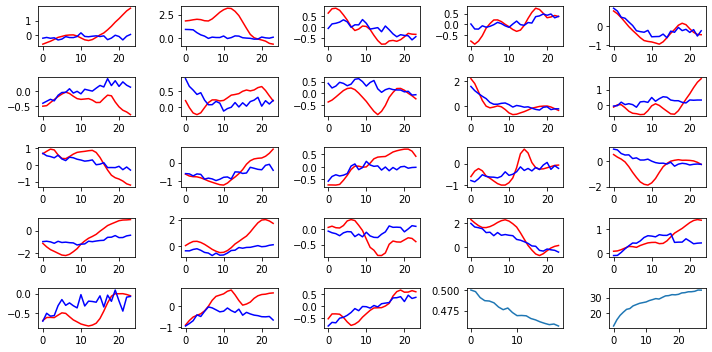

Step: 0, Train Loss: 0.5929970145225525
Step: 20, Train Loss: 0.482496440410614
Step: 40, Train Loss: 0.4151798188686371
Step: 60, Train Loss: 0.33434605598449707
Step: 80, Train Loss: 0.5325189232826233
Step: 100, Train Loss: 0.44976967573165894
Step: 120, Train Loss: 0.5928714275360107
Step: 140, Train Loss: 0.2942376136779785
Epoch: 29, Train loss: 0.45320927935421085
acskill_socre:51.1635086061987, rmse_score:15.861044663801517
Epoch: 29, Valid Score: 35.30246394239718
Model saved successfully


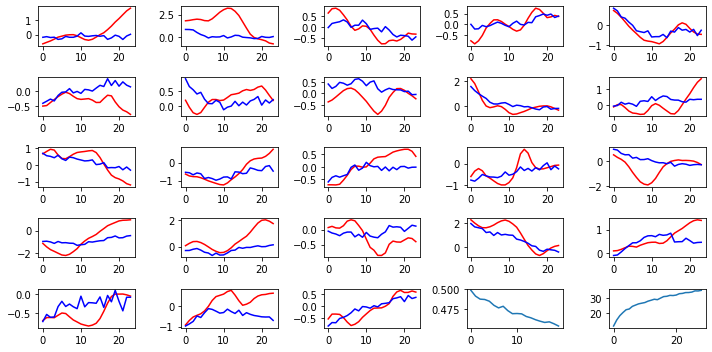

Step: 0, Train Loss: 0.5796163082122803
Step: 20, Train Loss: 0.47663792967796326
Step: 40, Train Loss: 0.5573917627334595
Step: 60, Train Loss: 0.34104251861572266
Step: 80, Train Loss: 0.33481988310813904
Step: 100, Train Loss: 0.4398631751537323
Step: 120, Train Loss: 0.42219293117523193
Step: 140, Train Loss: 0.5583302974700928
Epoch: 30, Train loss: 0.45683562869478944
acskill_socre:51.87525064035501, rmse_score:15.801285398589949
Epoch: 30, Valid Score: 36.073965241765066
Model saved successfully


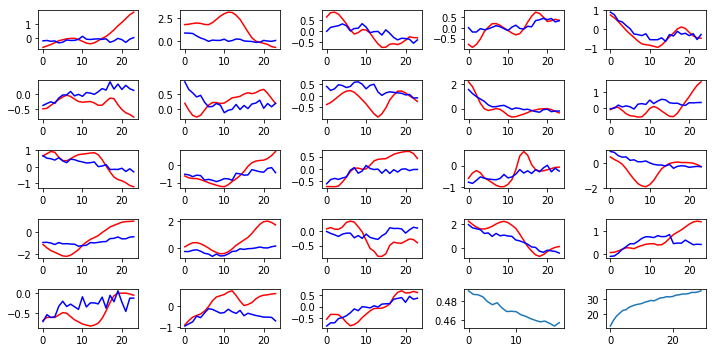

Step: 0, Train Loss: 0.4612848162651062
Step: 20, Train Loss: 0.5126190185546875
Step: 40, Train Loss: 0.3734740912914276
Step: 60, Train Loss: 0.3919449746608734
Step: 80, Train Loss: 0.4601622521877289
Step: 100, Train Loss: 0.3874797821044922
Step: 120, Train Loss: 0.4363093078136444
Step: 140, Train Loss: 0.39351487159729004
Epoch: 31, Train loss: 0.4527400923762352
acskill_socre:51.90203402825496, rmse_score:15.767549828125125
Epoch: 31, Valid Score: 36.13448420012983
Model saved successfully


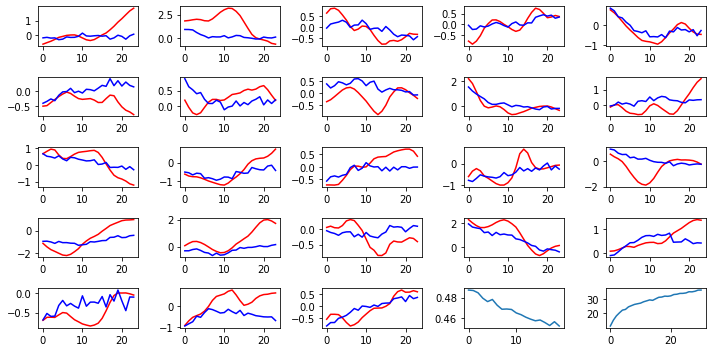

Step: 0, Train Loss: 0.3846505582332611
Step: 20, Train Loss: 0.5853099226951599
Step: 40, Train Loss: 0.34870046377182007
Step: 60, Train Loss: 0.44633007049560547
Step: 80, Train Loss: 0.5422175526618958
Step: 100, Train Loss: 0.447532057762146
Step: 120, Train Loss: 0.3525451123714447
Step: 140, Train Loss: 0.3555421829223633
Epoch: 32, Train loss: 0.4508395532893527
acskill_socre:51.80959041750066, rmse_score:15.781637980267437
Epoch: 32, Valid Score: 36.027952437233225


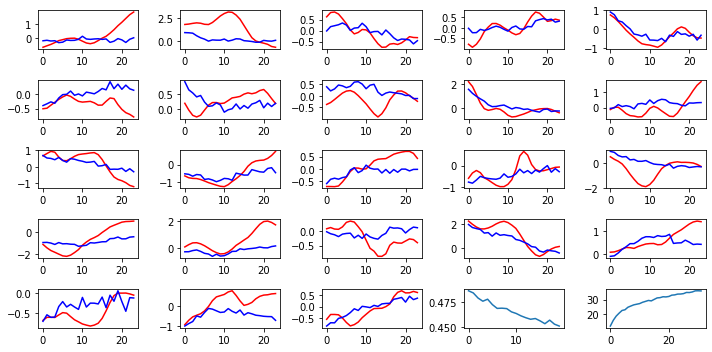

Step: 0, Train Loss: 0.513742208480835
Step: 20, Train Loss: 0.5046520829200745
Step: 40, Train Loss: 0.48890411853790283
Step: 60, Train Loss: 0.4729804992675781
Step: 80, Train Loss: 0.41731560230255127
Step: 100, Train Loss: 0.5340485572814941
Step: 120, Train Loss: 0.3748655915260315
Step: 140, Train Loss: 0.5476771593093872
Epoch: 33, Train loss: 0.4495863419998983
acskill_socre:51.39480094708845, rmse_score:15.807897844606929
Epoch: 33, Valid Score: 35.58690310248152


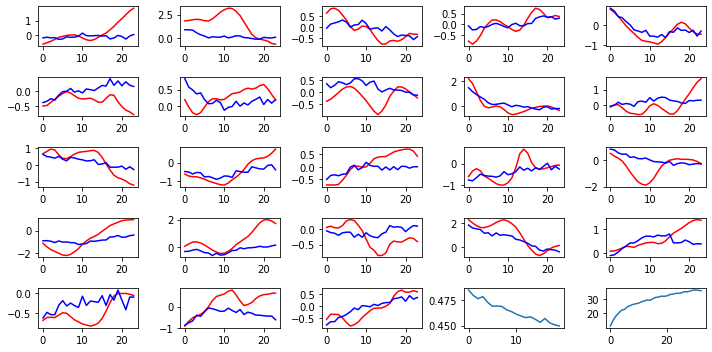

Step: 0, Train Loss: 0.3667631149291992
Step: 20, Train Loss: 0.43612241744995117
Step: 40, Train Loss: 0.33986520767211914
Step: 60, Train Loss: 0.38252270221710205
Step: 80, Train Loss: 0.36599478125572205
Step: 100, Train Loss: 0.4578954577445984
Step: 120, Train Loss: 0.7112550139427185
Step: 140, Train Loss: 0.38280272483825684
Epoch: 34, Train loss: 0.4495919680899116
acskill_socre:52.051628665872556, rmse_score:15.729635740420369
Epoch: 34, Valid Score: 36.321992925452186
Model saved successfully


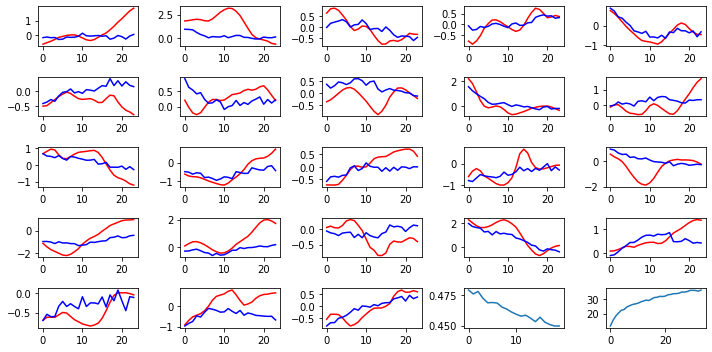

Step: 0, Train Loss: 0.5829694271087646
Step: 20, Train Loss: 0.5089658498764038
Step: 40, Train Loss: 0.4014046788215637
Step: 60, Train Loss: 0.4805811047554016
Step: 80, Train Loss: 0.3141854405403137
Step: 100, Train Loss: 0.40056926012039185
Step: 120, Train Loss: 0.5857303142547607
Step: 140, Train Loss: 0.6093938946723938
Epoch: 35, Train loss: 0.45250258608988136
acskill_socre:52.14851072511477, rmse_score:15.705148603826014
Epoch: 35, Valid Score: 36.44336212128876
Model saved successfully


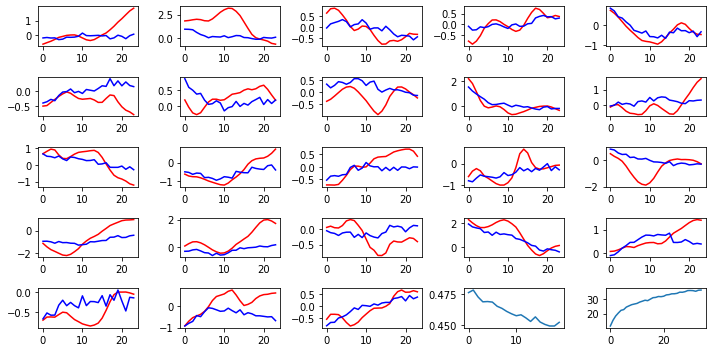

Step: 0, Train Loss: 0.3885379731655121
Step: 20, Train Loss: 0.46187958121299744
Step: 40, Train Loss: 0.4046463668346405
Step: 60, Train Loss: 0.35523638129234314
Step: 80, Train Loss: 0.39644092321395874
Step: 100, Train Loss: 0.44029903411865234
Step: 120, Train Loss: 0.40357694029808044
Step: 140, Train Loss: 0.4513040781021118
Epoch: 36, Train loss: 0.44900010175006405
acskill_socre:52.319194808336405, rmse_score:15.692925995076084
Epoch: 36, Valid Score: 36.626268813260324
Model saved successfully


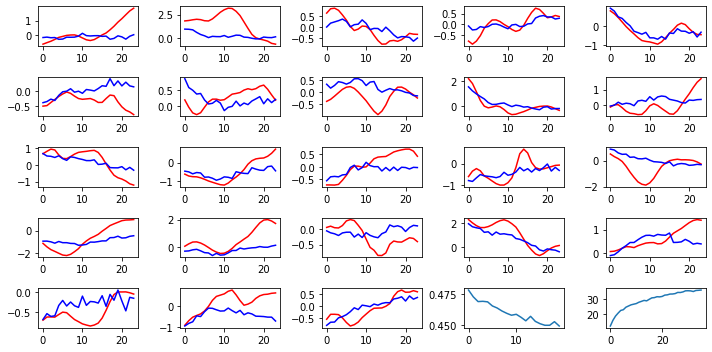

Step: 0, Train Loss: 0.34681254625320435
Step: 20, Train Loss: 0.6307365894317627
Step: 40, Train Loss: 0.4976382851600647
Step: 60, Train Loss: 0.47684451937675476
Step: 80, Train Loss: 0.4892582297325134
Step: 100, Train Loss: 0.5444189310073853
Step: 120, Train Loss: 0.5375348925590515
Step: 140, Train Loss: 0.27778345346450806
Epoch: 37, Train loss: 0.447407507213058
acskill_socre:52.59547185039845, rmse_score:15.631347456754153
Epoch: 37, Valid Score: 36.9641243936443
Model saved successfully


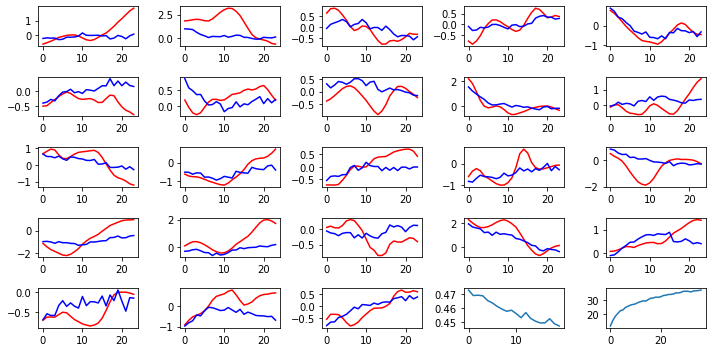

Step: 0, Train Loss: 0.34100162982940674
Step: 20, Train Loss: 0.44972825050354004
Step: 40, Train Loss: 0.3709130883216858
Step: 60, Train Loss: 0.390570729970932
Step: 80, Train Loss: 0.46314501762390137
Step: 100, Train Loss: 0.5590732097625732
Step: 120, Train Loss: 0.4257206618785858
Step: 140, Train Loss: 0.3280666470527649
Epoch: 38, Train loss: 0.44651349638677706
acskill_socre:52.19073190233747, rmse_score:15.688243496154788
Epoch: 38, Valid Score: 36.50248840618268


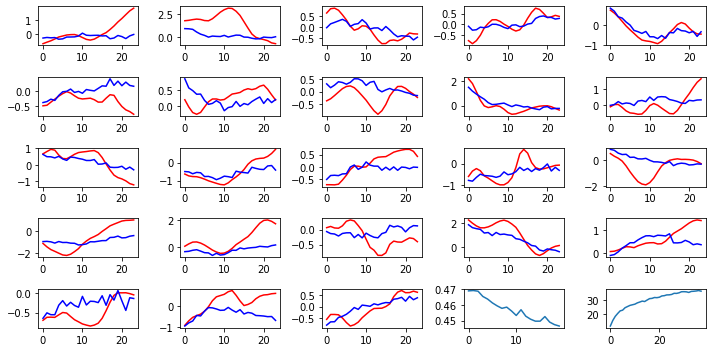

Step: 0, Train Loss: 0.5284675359725952
Step: 20, Train Loss: 0.5325043201446533
Step: 40, Train Loss: 0.48208773136138916
Step: 60, Train Loss: 0.3203495144844055
Step: 80, Train Loss: 0.5209326148033142
Step: 100, Train Loss: 0.34400081634521484
Step: 120, Train Loss: 0.4882131516933441
Step: 140, Train Loss: 0.48957082629203796
Epoch: 39, Train loss: 0.44408134603576294
acskill_socre:52.590000321110594, rmse_score:15.642728640631473
Epoch: 39, Valid Score: 36.94727168047912


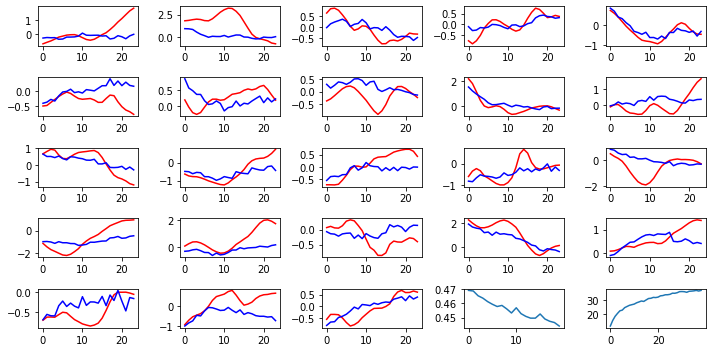

Step: 0, Train Loss: 0.5168216228485107
Step: 20, Train Loss: 0.5014551281929016
Step: 40, Train Loss: 0.45699018239974976
Step: 60, Train Loss: 0.7189382314682007
Step: 80, Train Loss: 0.39987462759017944
Step: 100, Train Loss: 0.5230413675308228
Step: 120, Train Loss: 0.3557729721069336
Step: 140, Train Loss: 0.44736695289611816
Epoch: 40, Train loss: 0.44576237991357304
acskill_socre:52.45163977817876, rmse_score:15.66803437385627
Epoch: 40, Valid Score: 36.783605404322486


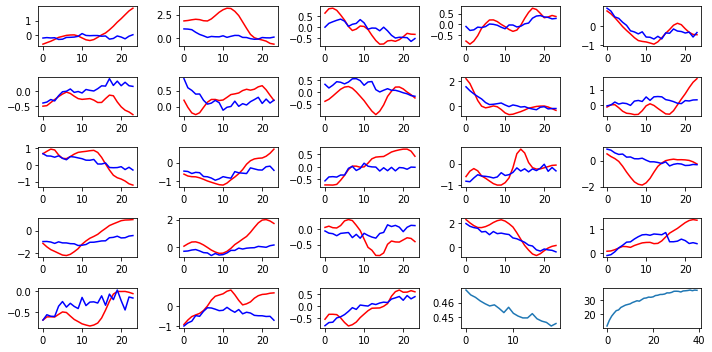

Step: 0, Train Loss: 0.48353660106658936
Step: 20, Train Loss: 0.3525214195251465
Step: 40, Train Loss: 0.29766255617141724
Step: 60, Train Loss: 0.5077238082885742
Step: 80, Train Loss: 0.43725866079330444
Step: 100, Train Loss: 0.4755704402923584
Step: 120, Train Loss: 0.3310263752937317
Step: 140, Train Loss: 0.47211211919784546
Epoch: 41, Train loss: 0.44276140791595364
acskill_socre:52.60339425512388, rmse_score:15.616266337459457
Epoch: 41, Valid Score: 36.987127917664424
Model saved successfully


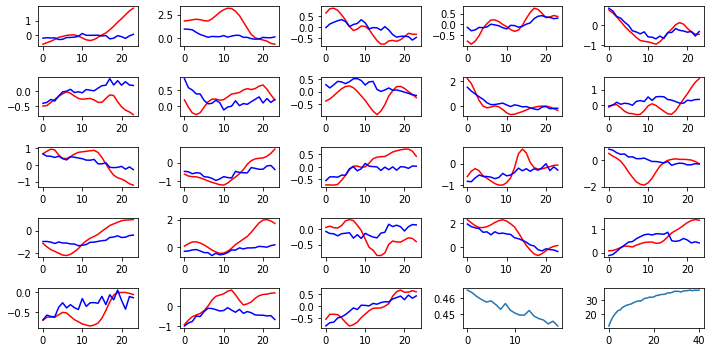

Step: 0, Train Loss: 0.436011403799057
Step: 20, Train Loss: 0.34334033727645874
Step: 40, Train Loss: 0.4657466411590576
Step: 60, Train Loss: 0.4584052562713623
Step: 80, Train Loss: 0.4047377109527588
Step: 100, Train Loss: 0.4303462505340576
Step: 120, Train Loss: 0.4451116919517517
Step: 140, Train Loss: 0.4145248830318451
Epoch: 42, Train loss: 0.44370380765313555
acskill_socre:53.07478692755249, rmse_score:15.596361363593202
Epoch: 42, Valid Score: 37.478425563959284
Model saved successfully


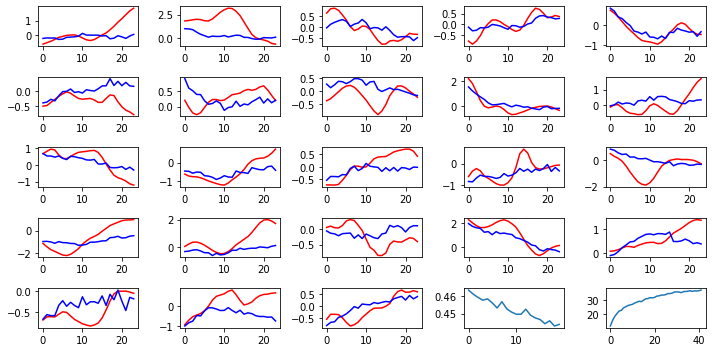

Step: 0, Train Loss: 0.44213199615478516
Step: 20, Train Loss: 0.40417367219924927
Step: 40, Train Loss: 0.5874404311180115
Step: 60, Train Loss: 0.45852527022361755
Step: 80, Train Loss: 0.35341304540634155
Step: 100, Train Loss: 0.4742558002471924
Step: 120, Train Loss: 0.44865041971206665
Step: 140, Train Loss: 0.446833074092865
Epoch: 43, Train loss: 0.44226083539094135
acskill_socre:53.0769981022806, rmse_score:15.565479222723575
Epoch: 43, Valid Score: 37.51151887955702
Model saved successfully


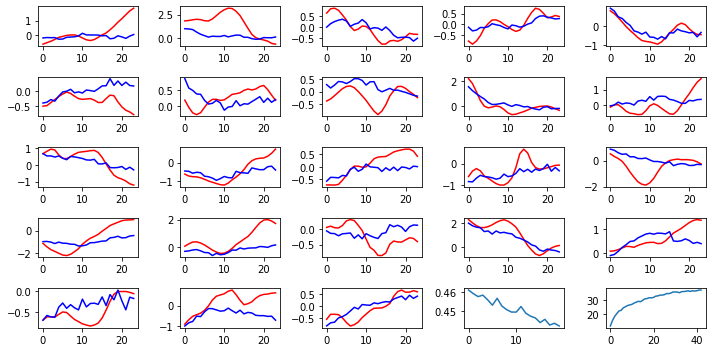

Step: 0, Train Loss: 0.4448244571685791
Step: 20, Train Loss: 0.5524513125419617
Step: 40, Train Loss: 0.5419704914093018
Step: 60, Train Loss: 0.44200024008750916
Step: 80, Train Loss: 0.5242719054222107
Step: 100, Train Loss: 0.41776013374328613
Step: 120, Train Loss: 0.5011608600616455
Step: 140, Train Loss: 0.36017823219299316
Epoch: 44, Train loss: 0.44026708935096764
acskill_socre:52.583047079605336, rmse_score:15.602799742742782
Epoch: 44, Valid Score: 36.980247336862554


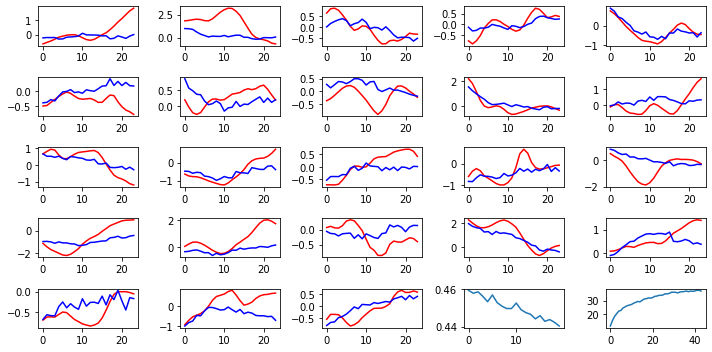

Step: 0, Train Loss: 0.4536692798137665
Step: 20, Train Loss: 0.496985524892807
Step: 40, Train Loss: 0.45119714736938477
Step: 60, Train Loss: 0.39688992500305176
Step: 80, Train Loss: 0.3148483633995056
Step: 100, Train Loss: 0.5958707928657532
Step: 120, Train Loss: 0.38330841064453125
Step: 140, Train Loss: 0.37018653750419617
Epoch: 45, Train loss: 0.4399054952108177
acskill_socre:53.26593360137343, rmse_score:15.529920980540098
Epoch: 45, Valid Score: 37.736012620833336
Model saved successfully


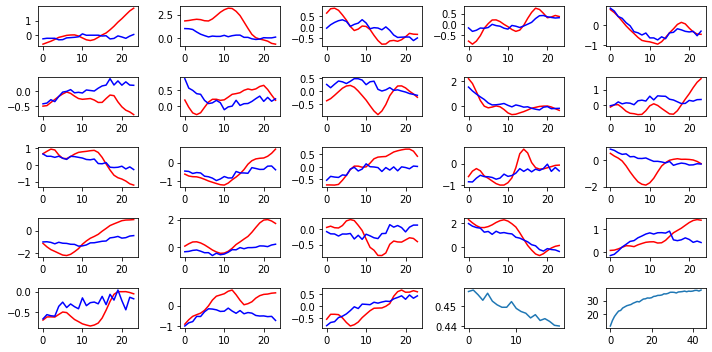

Step: 0, Train Loss: 0.4086781442165375
Step: 20, Train Loss: 0.4093884825706482
Step: 40, Train Loss: 0.46736711263656616
Step: 60, Train Loss: 0.6228656768798828
Step: 80, Train Loss: 0.5780799388885498
Step: 100, Train Loss: 0.32718390226364136
Step: 120, Train Loss: 0.495564341545105
Step: 140, Train Loss: 0.8406635522842407
Epoch: 46, Train loss: 0.4401946498709879
acskill_socre:53.053989884260915, rmse_score:15.55111088271363
Epoch: 46, Valid Score: 37.502879001547285


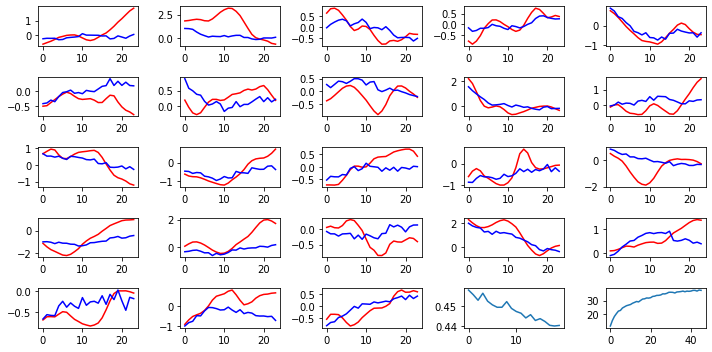

Step: 0, Train Loss: 0.41539067029953003
Step: 20, Train Loss: 0.5264569520950317
Step: 40, Train Loss: 0.5578629374504089
Step: 60, Train Loss: 0.41701945662498474
Step: 80, Train Loss: 0.3295269012451172
Step: 100, Train Loss: 0.40871644020080566
Step: 120, Train Loss: 0.4420059621334076
Step: 140, Train Loss: 0.3445383906364441
Epoch: 47, Train loss: 0.4394571530591151
acskill_socre:52.86465250158304, rmse_score:15.580261884278176
Epoch: 47, Valid Score: 37.284390617304865


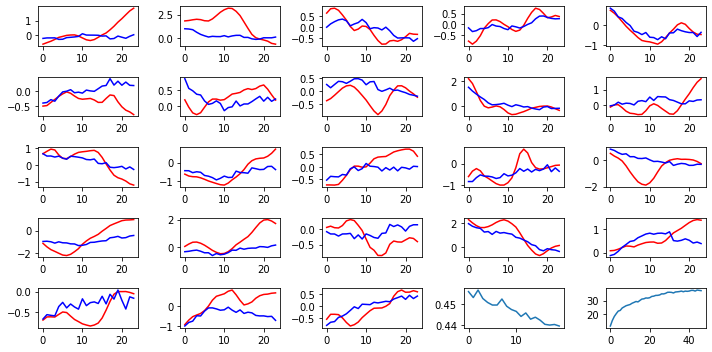

Step: 0, Train Loss: 0.39358794689178467
Step: 20, Train Loss: 0.3666999042034149
Step: 40, Train Loss: 0.4287871718406677
Step: 60, Train Loss: 0.46922731399536133
Step: 80, Train Loss: 0.3205797076225281
Step: 100, Train Loss: 0.3172234296798706
Step: 120, Train Loss: 0.4615935981273651
Step: 140, Train Loss: 0.45023927092552185
Epoch: 48, Train loss: 0.4370929424882315
acskill_socre:52.17803257891457, rmse_score:15.607512218360439
Epoch: 48, Valid Score: 36.57052036055413


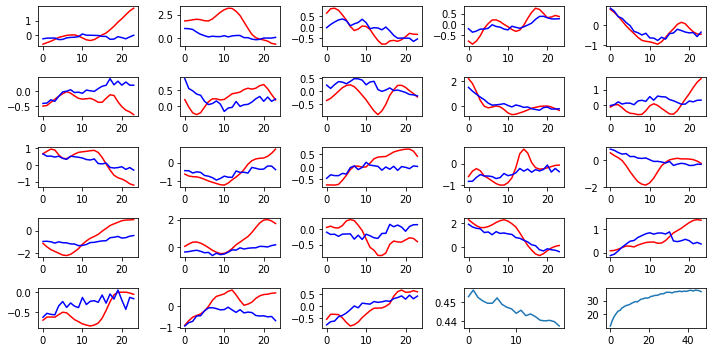

Step: 0, Train Loss: 0.40896767377853394
Step: 20, Train Loss: 0.34321415424346924
Step: 40, Train Loss: 0.365081250667572
Step: 60, Train Loss: 0.41853398084640503
Step: 80, Train Loss: 0.438814640045166
Step: 100, Train Loss: 0.4811440110206604
Step: 120, Train Loss: 0.5638021230697632
Step: 140, Train Loss: 0.44819176197052
Epoch: 49, Train loss: 0.44174615953378615
acskill_socre:53.10963215596803, rmse_score:15.549825160160228
Epoch: 49, Valid Score: 37.559806995807804


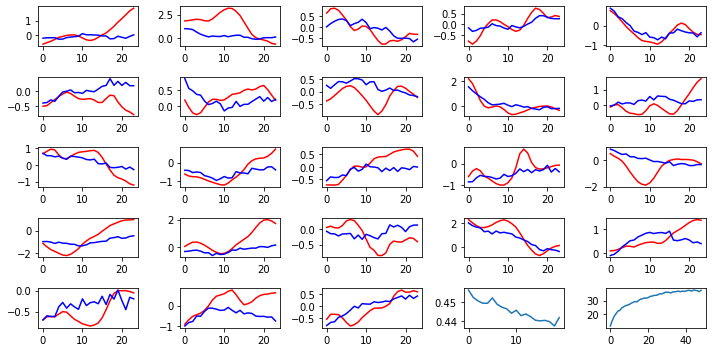

Step: 0, Train Loss: 0.4544771611690521
Step: 20, Train Loss: 0.31120190024375916
Step: 40, Train Loss: 0.5066925287246704
Step: 60, Train Loss: 0.43800029158592224
Step: 80, Train Loss: 0.3930264115333557
Step: 100, Train Loss: 0.5118511915206909
Step: 120, Train Loss: 0.39409106969833374
Step: 140, Train Loss: 0.48125284910202026
Epoch: 50, Train loss: 0.4397920860796218
acskill_socre:52.86188288949314, rmse_score:15.537628794544394
Epoch: 50, Valid Score: 37.32425409494874


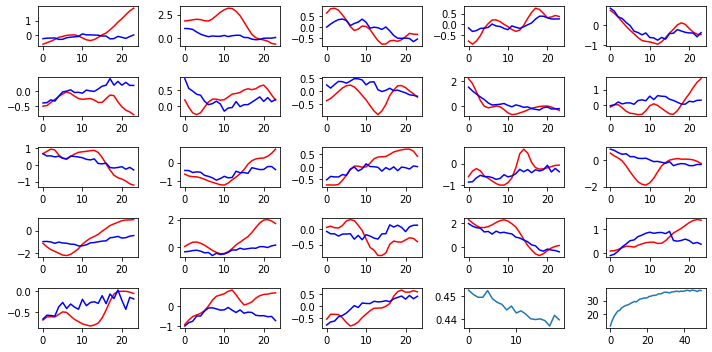

Step: 0, Train Loss: 0.6226894855499268
Step: 20, Train Loss: 0.47981172800064087
Step: 40, Train Loss: 0.3703776001930237
Step: 60, Train Loss: 0.355848491191864
Step: 80, Train Loss: 0.5105448961257935
Step: 100, Train Loss: 0.3585606515407562
Step: 120, Train Loss: 0.3077530264854431
Step: 140, Train Loss: 0.46451276540756226
Epoch: 51, Train loss: 0.4414518422381893
acskill_socre:53.013147365852184, rmse_score:15.537272437342462
Epoch: 51, Valid Score: 37.475874928509725


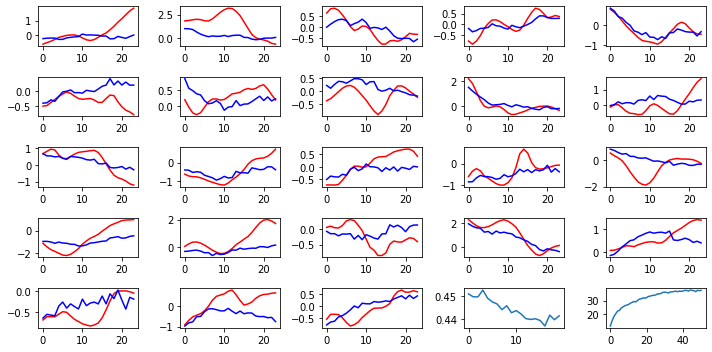

Step: 0, Train Loss: 0.402718186378479
Step: 20, Train Loss: 0.35500261187553406
Step: 40, Train Loss: 0.46003401279449463
Step: 60, Train Loss: 0.3523527979850769
Step: 80, Train Loss: 0.3448266386985779
Step: 100, Train Loss: 0.27855414152145386
Step: 120, Train Loss: 0.3842419981956482
Step: 140, Train Loss: 0.47760361433029175
Epoch: 52, Train loss: 0.43588043065967075
acskill_socre:52.74317489102236, rmse_score:15.552835744177145
Epoch: 52, Valid Score: 37.19033914684522


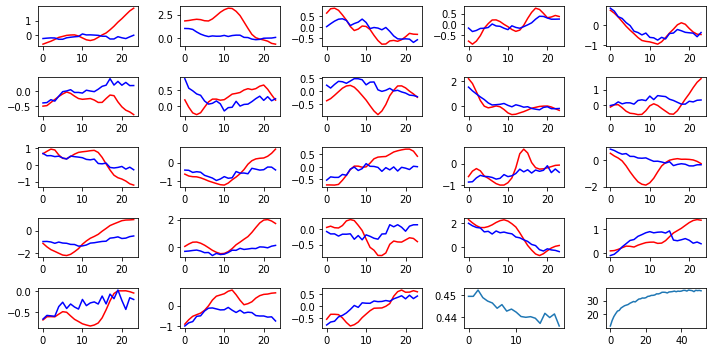

Step: 0, Train Loss: 0.3446739912033081
Step: 20, Train Loss: 0.5897594690322876
Step: 40, Train Loss: 0.5945608019828796
Step: 60, Train Loss: 0.37476038932800293
Step: 80, Train Loss: 0.5623632669448853
Step: 100, Train Loss: 0.4262036979198456
Step: 120, Train Loss: 0.4591289460659027
Step: 140, Train Loss: 0.45555925369262695
Epoch: 53, Train loss: 0.4375527556155138
acskill_socre:52.65389268178127, rmse_score:15.552693796931734
Epoch: 53, Valid Score: 37.10119888484954


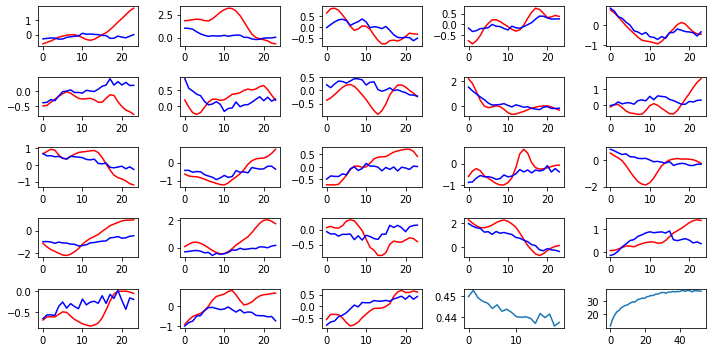

Step: 0, Train Loss: 0.4057576656341553
Step: 20, Train Loss: 0.7170512080192566
Step: 40, Train Loss: 0.3558564782142639
Step: 60, Train Loss: 0.42405399680137634
Step: 80, Train Loss: 0.4772478938102722
Step: 100, Train Loss: 0.3678215444087982
Step: 120, Train Loss: 0.36830615997314453
Step: 140, Train Loss: 0.4223858714103699
Epoch: 54, Train loss: 0.4361948213379854
acskill_socre:53.204526860570866, rmse_score:15.48889757056493
Epoch: 54, Valid Score: 37.715629290005936


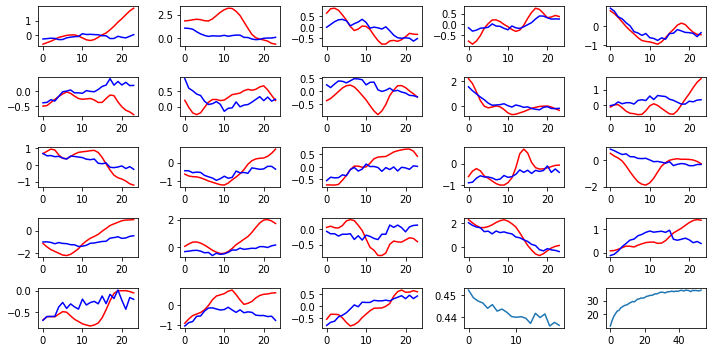

Step: 0, Train Loss: 0.399258553981781
Step: 20, Train Loss: 0.3333066701889038
Step: 40, Train Loss: 0.6290696263313293
Step: 60, Train Loss: 0.38319313526153564
Step: 80, Train Loss: 0.5056207180023193
Step: 100, Train Loss: 0.5943161249160767
Step: 120, Train Loss: 0.3600674569606781
Step: 140, Train Loss: 0.5261030197143555
Epoch: 55, Train loss: 0.4360263550737102
acskill_socre:52.73519863834946, rmse_score:15.535922518446824
Epoch: 55, Valid Score: 37.199276119902635


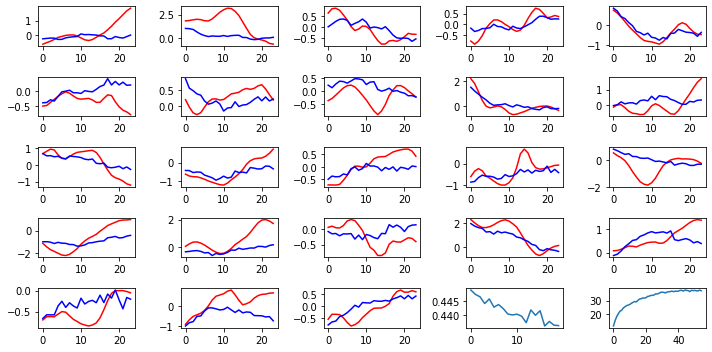

Step: 0, Train Loss: 0.44029006361961365
Step: 20, Train Loss: 0.4618436098098755
Step: 40, Train Loss: 0.34491801261901855
Step: 60, Train Loss: 0.5129138231277466
Step: 80, Train Loss: 0.3127581775188446
Step: 100, Train Loss: 0.46906349062919617
Step: 120, Train Loss: 0.3991565406322479
Step: 140, Train Loss: 0.43036091327667236
Epoch: 56, Train loss: 0.43630725524987385
acskill_socre:52.918642786664925, rmse_score:15.53191250899332
Epoch: 56, Valid Score: 37.3867302776716


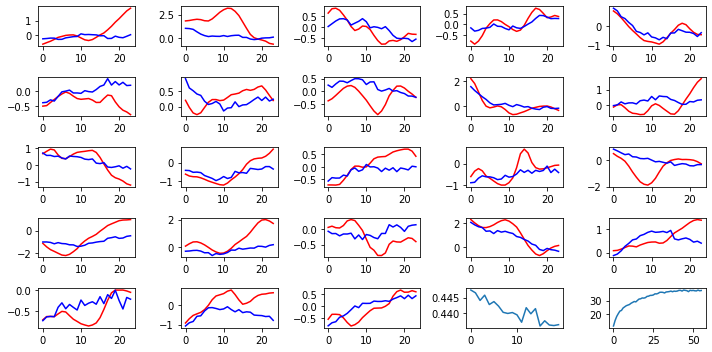

Step: 0, Train Loss: 0.4825385510921478
Step: 20, Train Loss: 0.43304747343063354
Step: 40, Train Loss: 0.47616738080978394
Step: 60, Train Loss: 0.42426297068595886
Step: 80, Train Loss: 0.41369080543518066
Step: 100, Train Loss: 0.3646236062049866
Step: 120, Train Loss: 0.5559155344963074
Step: 140, Train Loss: 0.30672913789749146
Epoch: 57, Train loss: 0.4351030115488988
acskill_socre:52.91640827944256, rmse_score:15.511765084570243
Epoch: 57, Valid Score: 37.404643194872314


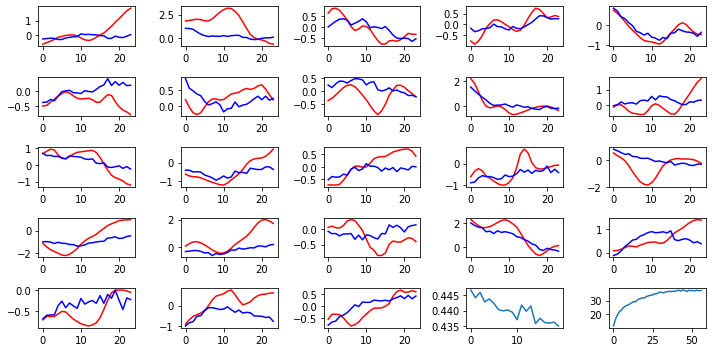

Step: 0, Train Loss: 0.4749687612056732
Step: 20, Train Loss: 0.298953652381897
Step: 40, Train Loss: 0.4314537048339844
Step: 60, Train Loss: 0.3538396954536438
Step: 80, Train Loss: 0.49026650190353394
Step: 100, Train Loss: 0.45751523971557617
Step: 120, Train Loss: 0.40957778692245483
Step: 140, Train Loss: 0.4836704134941101
Epoch: 58, Train loss: 0.43335105602148993
acskill_socre:53.0339884413418, rmse_score:15.510546122036185
Epoch: 58, Valid Score: 37.523442319305616


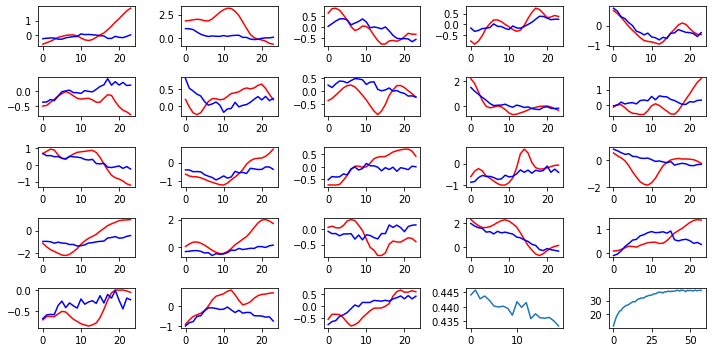

Step: 0, Train Loss: 0.38188618421554565
Step: 20, Train Loss: 0.4692813754081726
Step: 40, Train Loss: 0.5104004144668579
Step: 60, Train Loss: 0.5311599969863892
Step: 80, Train Loss: 0.43201130628585815
Step: 100, Train Loss: 0.5198425054550171
Step: 120, Train Loss: 0.289692223072052
Step: 140, Train Loss: 0.5689586400985718
Epoch: 59, Train loss: 0.43471992414468413
acskill_socre:52.96976743202171, rmse_score:15.498545227337283
Epoch: 59, Valid Score: 37.47122220468443


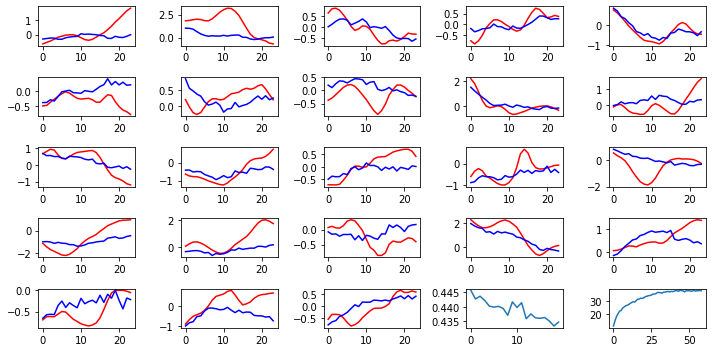

Step: 0, Train Loss: 0.5056667327880859
Step: 20, Train Loss: 0.40474843978881836
Step: 40, Train Loss: 0.4183024764060974
Step: 60, Train Loss: 0.4943101406097412
Step: 80, Train Loss: 0.4178963601589203
Step: 100, Train Loss: 0.34195876121520996
Step: 120, Train Loss: 0.4238390326499939
Step: 140, Train Loss: 0.36300036311149597
Epoch: 60, Train loss: 0.4329787384552561
acskill_socre:52.109278833465204, rmse_score:15.553223510712149
Epoch: 60, Valid Score: 36.55605532275305


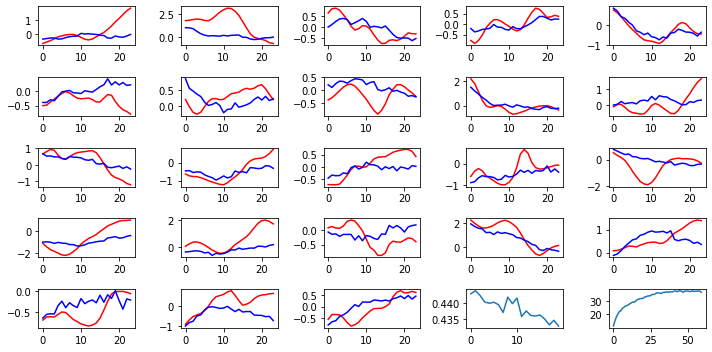

Step: 0, Train Loss: 0.5186576247215271
Step: 20, Train Loss: 0.43467193841934204
Step: 40, Train Loss: 0.46307629346847534
Step: 60, Train Loss: 0.5573320388793945
Step: 80, Train Loss: 0.49297961592674255
Step: 100, Train Loss: 0.4085209369659424
Step: 120, Train Loss: 0.4598119854927063
Step: 140, Train Loss: 0.6205819845199585
Epoch: 61, Train loss: 0.4323742803494642
acskill_socre:53.001843121208296, rmse_score:15.494653528217254
Epoch: 61, Valid Score: 37.50718959299104


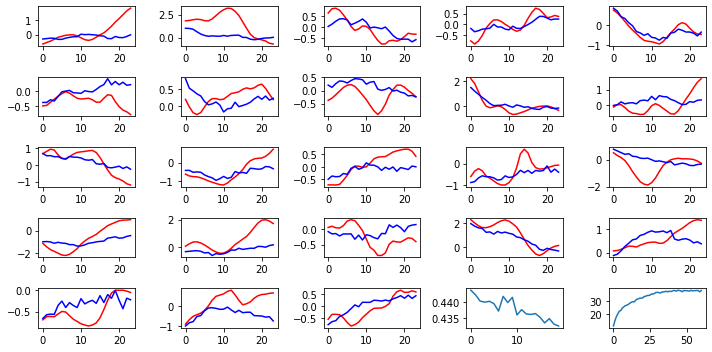

Step: 0, Train Loss: 0.4163978099822998
Step: 20, Train Loss: 0.2864302396774292
Step: 40, Train Loss: 0.46116897463798523
Step: 60, Train Loss: 0.48012232780456543
Step: 80, Train Loss: 0.4037559926509857
Step: 100, Train Loss: 0.27160903811454773
Step: 120, Train Loss: 0.4117024540901184
Step: 140, Train Loss: 0.32679224014282227
Epoch: 62, Train loss: 0.43945586681365967
acskill_socre:53.37661570560189, rmse_score:15.454131529773552
Epoch: 62, Valid Score: 37.922484175828345
Model saved successfully


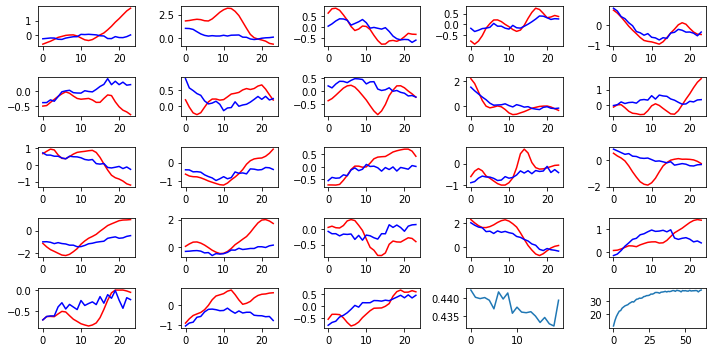

Step: 0, Train Loss: 0.3605532646179199
Step: 20, Train Loss: 0.4011818766593933
Step: 40, Train Loss: 0.4212007224559784
Step: 60, Train Loss: 0.5242644548416138
Step: 80, Train Loss: 0.40279948711395264
Step: 100, Train Loss: 0.47373756766319275
Step: 120, Train Loss: 0.6360735893249512
Step: 140, Train Loss: 0.5562893152236938
Epoch: 63, Train loss: 0.43560027449753635
acskill_socre:53.091560373233285, rmse_score:15.477807166896385
Epoch: 63, Valid Score: 37.6137532063369


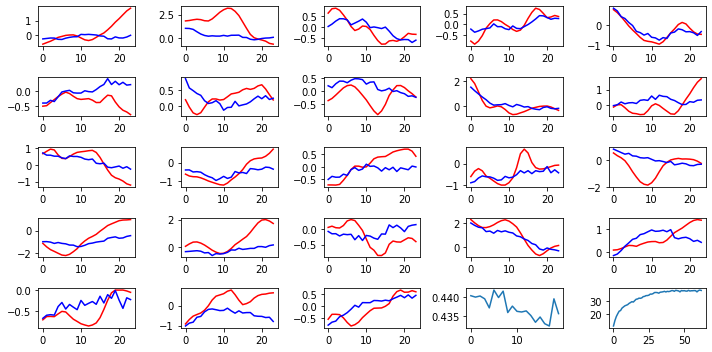

Step: 0, Train Loss: 0.35179194808006287
Step: 20, Train Loss: 0.3767368197441101
Step: 40, Train Loss: 0.3394109010696411
Step: 60, Train Loss: 0.5795169472694397
Step: 80, Train Loss: 0.4111400544643402
Step: 100, Train Loss: 0.4824657440185547
Step: 120, Train Loss: 0.491382896900177
Step: 140, Train Loss: 0.5354421138763428
Epoch: 64, Train loss: 0.4307085501540239
acskill_socre:52.498458441960054, rmse_score:15.515154761335179
Epoch: 64, Valid Score: 36.98330368062487


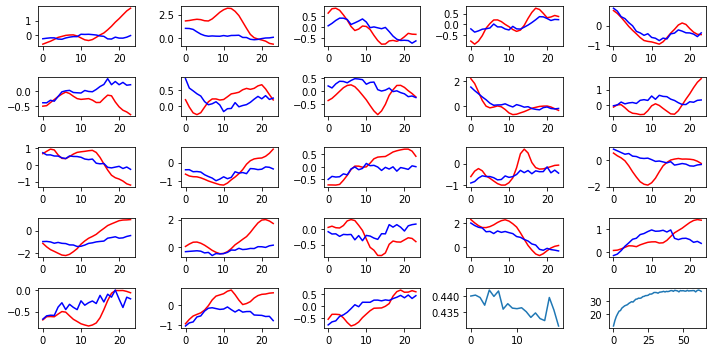

Step: 0, Train Loss: 0.4806978106498718
Step: 20, Train Loss: 0.5337802171707153
Step: 40, Train Loss: 0.46178850531578064
Step: 60, Train Loss: 0.4679584503173828
Step: 80, Train Loss: 0.4398965537548065
Step: 100, Train Loss: 0.4137527346611023
Step: 120, Train Loss: 0.5066756010055542
Step: 140, Train Loss: 0.3967318534851074
Epoch: 65, Train loss: 0.4293946976874285
acskill_socre:52.56453670210112, rmse_score:15.50862860808026
Epoch: 65, Valid Score: 37.055908094020864


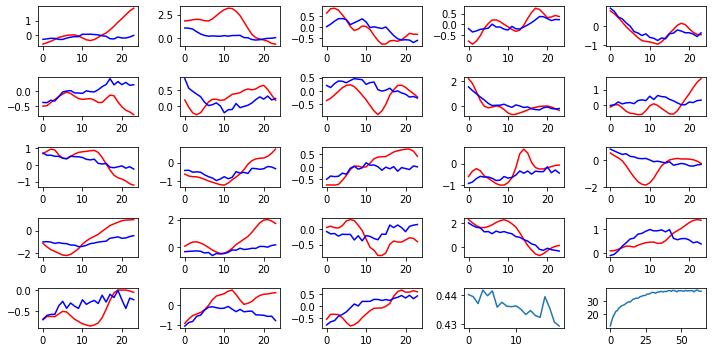

Step: 0, Train Loss: 0.40846264362335205
Step: 20, Train Loss: 0.38395676016807556
Step: 40, Train Loss: 0.3936571478843689
Step: 60, Train Loss: 0.4011635482311249
Step: 80, Train Loss: 0.39079535007476807
Step: 100, Train Loss: 0.3404286801815033
Step: 120, Train Loss: 0.37424492835998535
Step: 140, Train Loss: 0.3089568018913269
Epoch: 66, Train loss: 0.4325042896589656
acskill_socre:53.50046701570389, rmse_score:15.437599725359348
Epoch: 66, Valid Score: 38.06286729034454
Model saved successfully


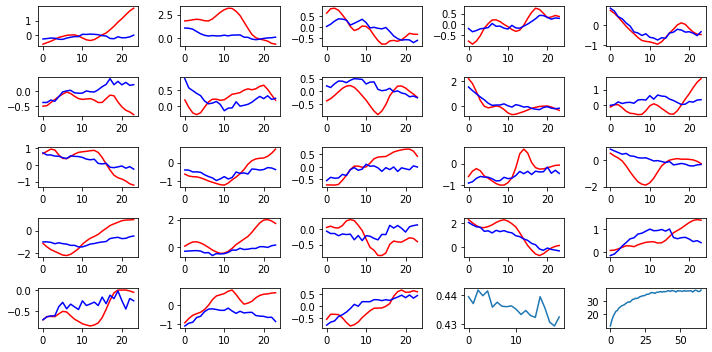

Step: 0, Train Loss: 0.4556310176849365
Step: 20, Train Loss: 0.47839266061782837
Step: 40, Train Loss: 0.2604515254497528
Step: 60, Train Loss: 0.5362389087677002
Step: 80, Train Loss: 0.4613662660121918
Step: 100, Train Loss: 0.43616223335266113
Step: 120, Train Loss: 0.38732123374938965
Step: 140, Train Loss: 0.349606990814209
Epoch: 67, Train loss: 0.4311468753085774
acskill_socre:52.54045767676636, rmse_score:15.527458867823274
Epoch: 67, Valid Score: 37.01299880894308


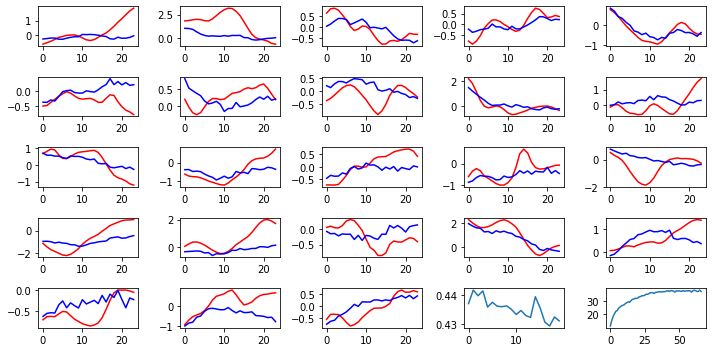

Step: 0, Train Loss: 0.5463811159133911
Step: 20, Train Loss: 0.5560162663459778
Step: 40, Train Loss: 0.3864881992340088
Step: 60, Train Loss: 0.36560720205307007
Step: 80, Train Loss: 0.4904409646987915
Step: 100, Train Loss: 0.660636842250824
Step: 120, Train Loss: 0.4877251088619232
Step: 140, Train Loss: 0.4898912310600281
Epoch: 68, Train loss: 0.4293422661958986
acskill_socre:52.88366296660034, rmse_score:15.468614972842344
Epoch: 68, Valid Score: 37.415047993757995


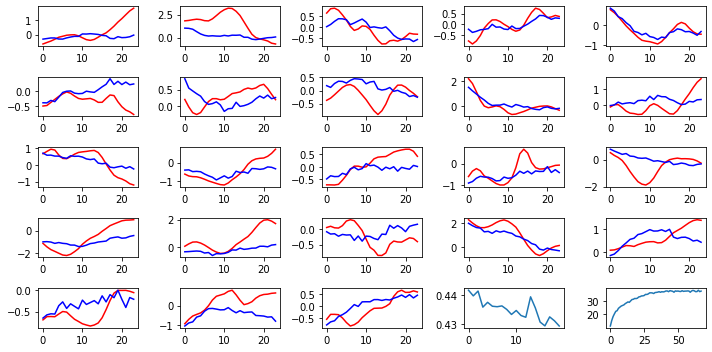

Step: 0, Train Loss: 0.47072696685791016
Step: 20, Train Loss: 0.4745432138442993
Step: 40, Train Loss: 0.525423526763916
Step: 60, Train Loss: 0.3405202329158783
Step: 80, Train Loss: 0.4440380036830902
Step: 100, Train Loss: 0.4820868670940399
Step: 120, Train Loss: 0.3668091297149658
Step: 140, Train Loss: 0.44440972805023193
Epoch: 69, Train loss: 0.43021276213560894
acskill_socre:52.34438075088614, rmse_score:15.500878486209626
Epoch: 69, Valid Score: 36.843502264676516


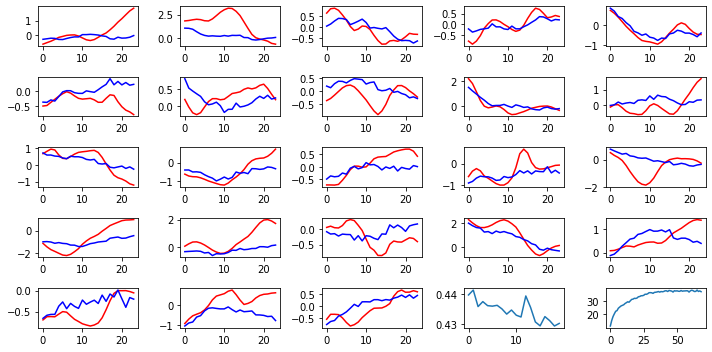

Step: 0, Train Loss: 0.3040679097175598
Step: 20, Train Loss: 0.37917041778564453
Step: 40, Train Loss: 0.49194154143333435
Step: 60, Train Loss: 0.4118193984031677
Step: 80, Train Loss: 0.5286040306091309
Step: 100, Train Loss: 0.4526488184928894
Step: 120, Train Loss: 0.33555492758750916
Step: 140, Train Loss: 0.2980682849884033
Epoch: 70, Train loss: 0.430199971434417
acskill_socre:52.595196041403206, rmse_score:15.48485615779685
Epoch: 70, Valid Score: 37.11033988360636


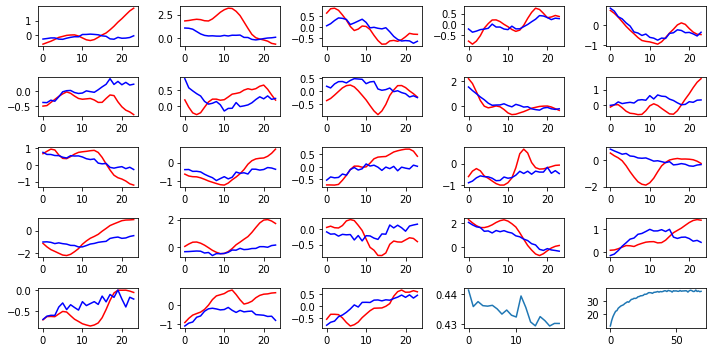

Step: 0, Train Loss: 0.562548041343689
Step: 20, Train Loss: 0.48281943798065186
Step: 40, Train Loss: 0.5352413058280945
Step: 60, Train Loss: 0.4960058629512787
Step: 80, Train Loss: 0.4775509834289551
Step: 100, Train Loss: 0.3656504154205322
Step: 120, Train Loss: 0.44879859685897827
Step: 140, Train Loss: 0.3074665069580078
Epoch: 71, Train loss: 0.4294571834764663
acskill_socre:52.4666723857581, rmse_score:15.50617496992357
Epoch: 71, Valid Score: 36.96049741583453


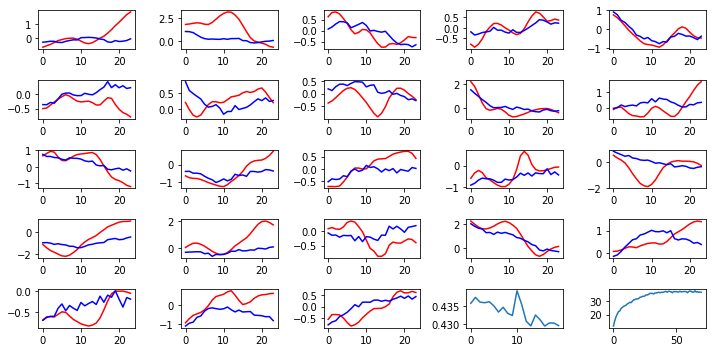

Step: 0, Train Loss: 0.36310476064682007
Step: 20, Train Loss: 0.37328410148620605
Step: 40, Train Loss: 0.4243522882461548
Step: 60, Train Loss: 0.4382716119289398
Step: 80, Train Loss: 0.4265463352203369
Step: 100, Train Loss: 0.3239569664001465
Step: 120, Train Loss: 0.32098084688186646
Step: 140, Train Loss: 0.3673359751701355
Epoch: 72, Train loss: 0.42903251120239305
acskill_socre:52.820006449883664, rmse_score:15.490284357733662
Epoch: 72, Valid Score: 37.32972209215


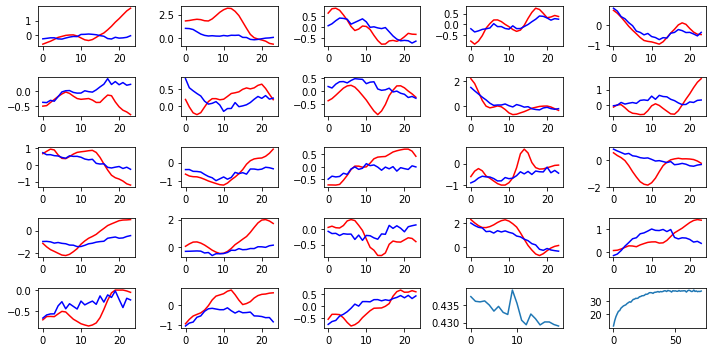

Step: 0, Train Loss: 0.39542755484580994
Step: 20, Train Loss: 0.4650089740753174
Step: 40, Train Loss: 0.3833116888999939
Step: 60, Train Loss: 0.37797412276268005
Step: 80, Train Loss: 0.4759550094604492
Step: 100, Train Loss: 0.36470675468444824
Step: 120, Train Loss: 0.48124265670776367
Step: 140, Train Loss: 0.41889846324920654
Epoch: 73, Train loss: 0.42915280039902703
acskill_socre:52.73032993638384, rmse_score:15.482200521408323
Epoch: 73, Valid Score: 37.248129414975516


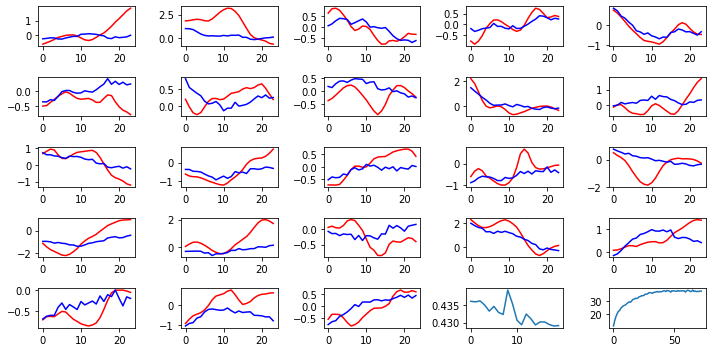

Step: 0, Train Loss: 0.5068434476852417
Step: 20, Train Loss: 0.3505403995513916
Step: 40, Train Loss: 0.4234803318977356
Step: 60, Train Loss: 0.2746332883834839
Step: 80, Train Loss: 0.4430391192436218
Step: 100, Train Loss: 0.49807196855545044
Step: 120, Train Loss: 0.402258038520813
Step: 140, Train Loss: 0.568224310874939
Epoch: 74, Train loss: 0.42770321297038133
acskill_socre:52.81301803811144, rmse_score:15.454018541866688
Epoch: 74, Valid Score: 37.35899949624475


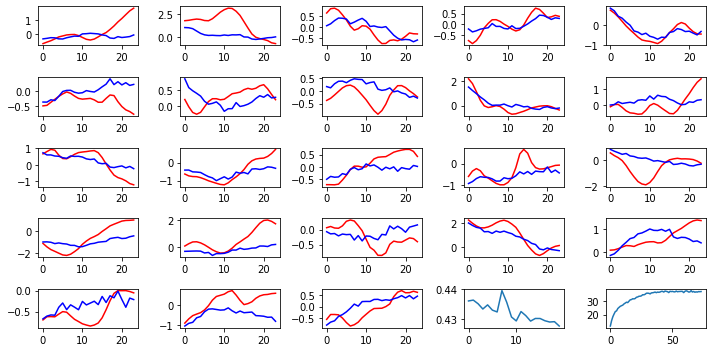

Step: 0, Train Loss: 0.5377733707427979
Step: 20, Train Loss: 0.48793157935142517
Step: 40, Train Loss: 0.5054775476455688
Step: 60, Train Loss: 0.4229739308357239
Step: 80, Train Loss: 0.37382441759109497
Step: 100, Train Loss: 0.330358624458313
Step: 120, Train Loss: 0.4922822415828705
Step: 140, Train Loss: 0.5076265335083008
Epoch: 75, Train loss: 0.4280723247938095
acskill_socre:52.73442550793284, rmse_score:15.471572765076008
Epoch: 75, Valid Score: 37.262852742856836


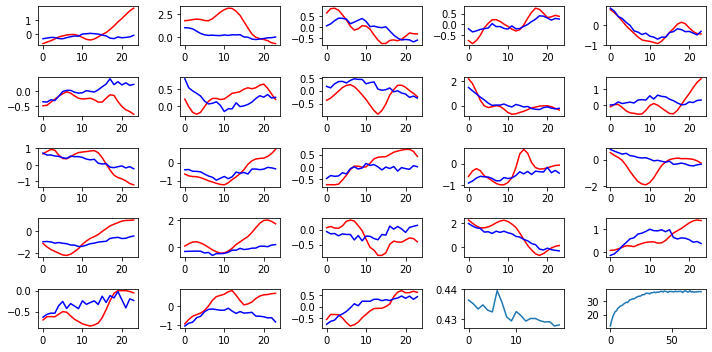

Step: 0, Train Loss: 0.3311772346496582
Step: 20, Train Loss: 0.32375022768974304
Step: 40, Train Loss: 0.34534773230552673
Step: 60, Train Loss: 0.49696215987205505
Step: 80, Train Loss: 0.2499406784772873
Step: 100, Train Loss: 0.39397305250167847
Step: 120, Train Loss: 0.4063471257686615
Step: 140, Train Loss: 0.43898582458496094
Epoch: 76, Train loss: 0.42743050340254596
acskill_socre:52.453511488143036, rmse_score:15.477459386809247
Epoch: 76, Valid Score: 36.97605210133379


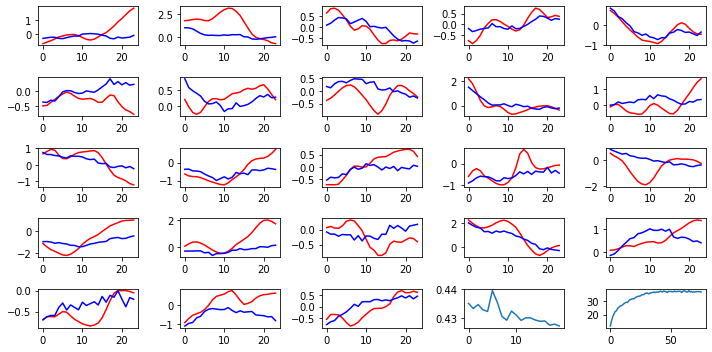

Step: 0, Train Loss: 0.3251032531261444
Step: 20, Train Loss: 0.490888774394989
Step: 40, Train Loss: 0.36571526527404785
Step: 60, Train Loss: 0.38240182399749756
Step: 80, Train Loss: 0.4338320195674896
Step: 100, Train Loss: 0.45891273021698
Step: 120, Train Loss: 0.5532827973365784
Step: 140, Train Loss: 0.3926142156124115
Epoch: 77, Train loss: 0.4295079584713954
acskill_socre:52.50421781979197, rmse_score:15.490077086731874
Epoch: 77, Valid Score: 37.014140733060096


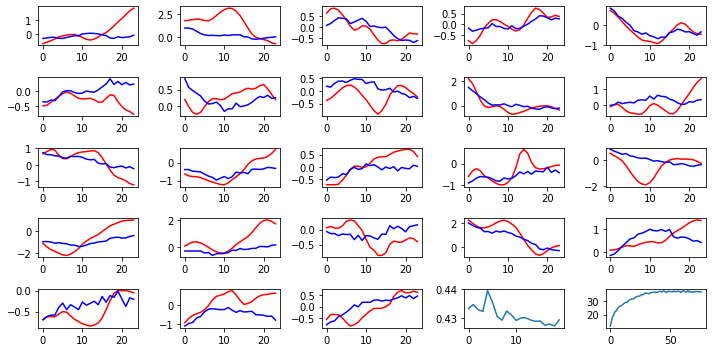

Step: 0, Train Loss: 0.3403948247432709
Step: 20, Train Loss: 0.4324192404747009
Step: 40, Train Loss: 0.4855493903160095
Step: 60, Train Loss: 0.373786985874176
Step: 80, Train Loss: 0.4952329397201538
Step: 100, Train Loss: 0.4303780496120453
Step: 120, Train Loss: 0.381163090467453
Step: 140, Train Loss: 0.31524181365966797
Epoch: 78, Train loss: 0.42980106374260724
acskill_socre:52.12631459958469, rmse_score:15.516902082043263
Epoch: 78, Valid Score: 36.60941251754143


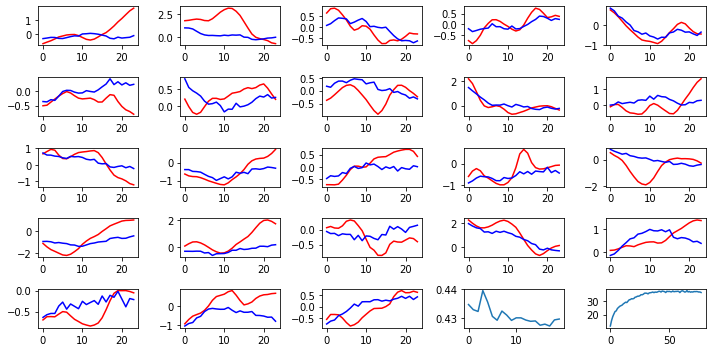

Step: 0, Train Loss: 0.3728870153427124
Step: 20, Train Loss: 0.2503405213356018
Step: 40, Train Loss: 0.3866628110408783
Step: 60, Train Loss: 0.4212889075279236
Step: 80, Train Loss: 0.4767845571041107
Step: 100, Train Loss: 0.3265998959541321
Step: 120, Train Loss: 0.3800508379936218
Step: 140, Train Loss: 0.3596266210079193
Epoch: 79, Train loss: 0.4288103665895523
acskill_socre:52.16048682847825, rmse_score:15.491430534944056
Epoch: 79, Valid Score: 36.66905629353419


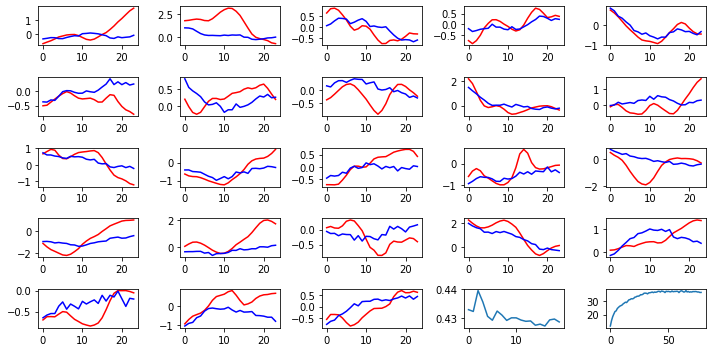

Step: 0, Train Loss: 0.40385890007019043
Step: 20, Train Loss: 0.5054521560668945
Step: 40, Train Loss: 0.44866371154785156
Step: 60, Train Loss: 0.46886810660362244
Step: 80, Train Loss: 0.42380544543266296
Step: 100, Train Loss: 0.4517032504081726
Step: 120, Train Loss: 0.3380698561668396
Step: 140, Train Loss: 0.3933327794075012
Epoch: 80, Train loss: 0.4262858530518356
acskill_socre:52.65351750657952, rmse_score:15.447994914043381
Epoch: 80, Valid Score: 37.20552259253614


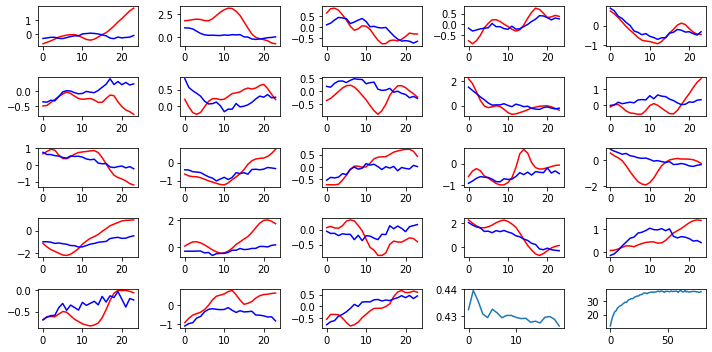

In [14]:
train(num_epochs=80)

In [15]:
model.load_state_dict(torch.load('models/basemodel_best.pt'))

<All keys matched successfully>

In [16]:
test_path = './tcdata/enso_round1_test_20210201/'

### load test data
files = os.listdir(test_path)
test_feas_dict = {}
for file in files:
    test_feas_dict[file] = np.load(test_path + file)

In [17]:
### 2. predict
test_predicts_dict = {}
for file_name, val in test_feas_dict.items():
    SST = np.expand_dims(val[:,:,:,0],axis=0)
    T300 = np.expand_dims(val[:,:,:,1],axis=0)
    Ua = np.expand_dims(val[:,:,:,2],axis=0)
    Va = np.expand_dims(val[:,:,:,3],axis=0)
    
    SST = np.nan_to_num(SST) # trans nan to 0
    T300 = np.nan_to_num(T300)
    Ua = np.nan_to_num(Ua)
    Va = np.nan_to_num(Va)
    
    data_list = [SST,T300,Ua,Va]
    SST,T300,Ua,Va = fit_data(data_list, fit=False)

    SST = torch.tensor(SST).to(device).float()
    T300 = torch.tensor(T300).to(device).float()
    Ua = torch.tensor(Ua).to(device).float()
    Va = torch.tensor(Va).to(device).float()
    
    result = model(SST, T300, Ua, Va).view(-1).detach().cpu().numpy()
    test_predicts_dict[file_name] = result

(20736, 4)


NotFittedError: This StandardScaler instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [ ]:
### 3. save results
if os.path.exists('./result/'):  
    shutil.rmtree('./result/', ignore_errors=True)  
os.makedirs('./result/')
for file_name, val in test_predicts_dict.items(): 
    np.save('./result/' + file_name, val)

In [ ]:
def make_zip(res_dir='./result', output_dir='result.zip'):  
    z = zipfile.ZipFile(output_dir, 'w')  
    for file in os.listdir(res_dir):  
        if '.npy' not in file:
            continue
        z.write(res_dir + os.sep + file)  
    z.close()

In [ ]:
make_zip()